# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
import nltk
nltk.download(['punkt', 'wordnet','stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lamiakasmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lamiakasmi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lamiakasmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 20),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
# load data from database
def load_data():
    engine = create_engine('sqlite:///DisasterResponse.db')
    df = pd.read_sql_table('Messages',engine)
    X = df['message']
    Y = df.iloc[:,4:]
    return X,Y
X,Y = load_data()

## Exploration

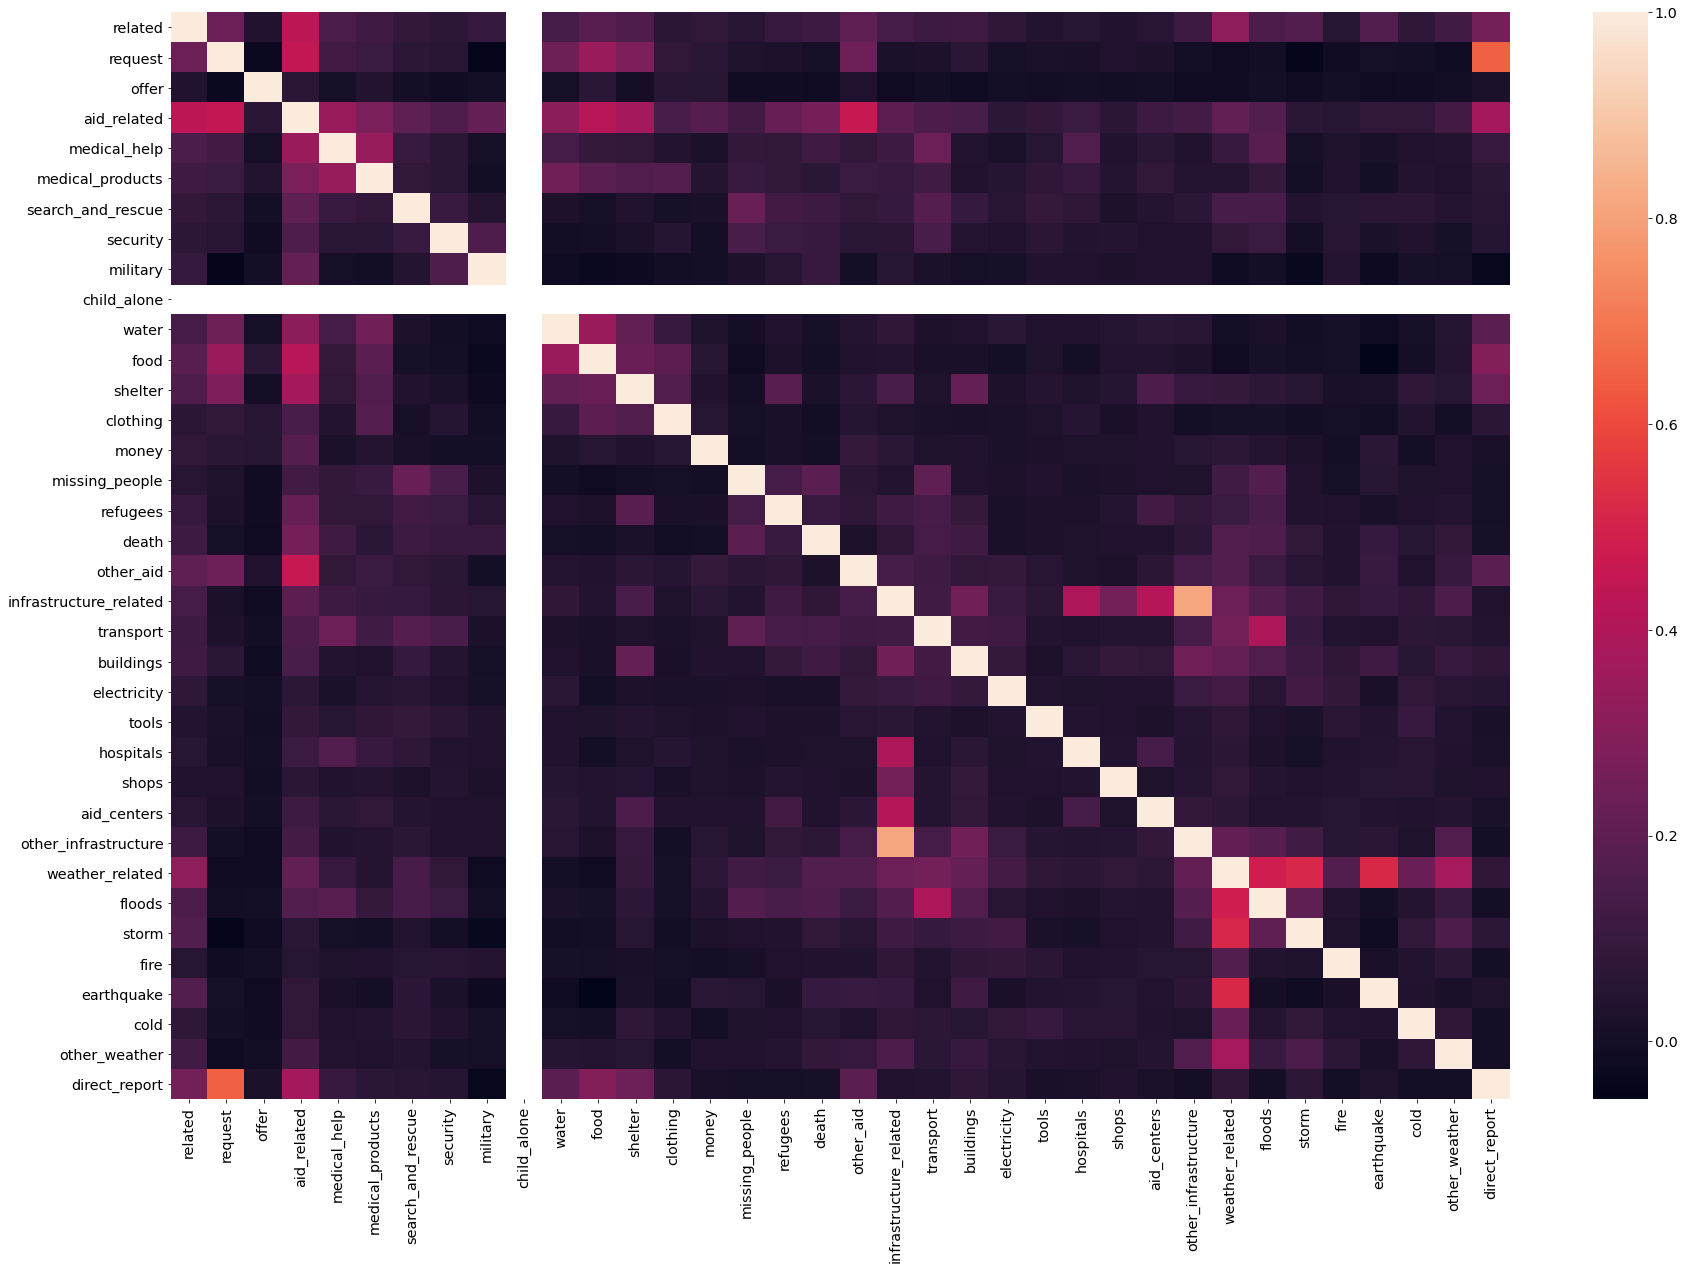

In [55]:
sns.heatmap(Y.corr()) 

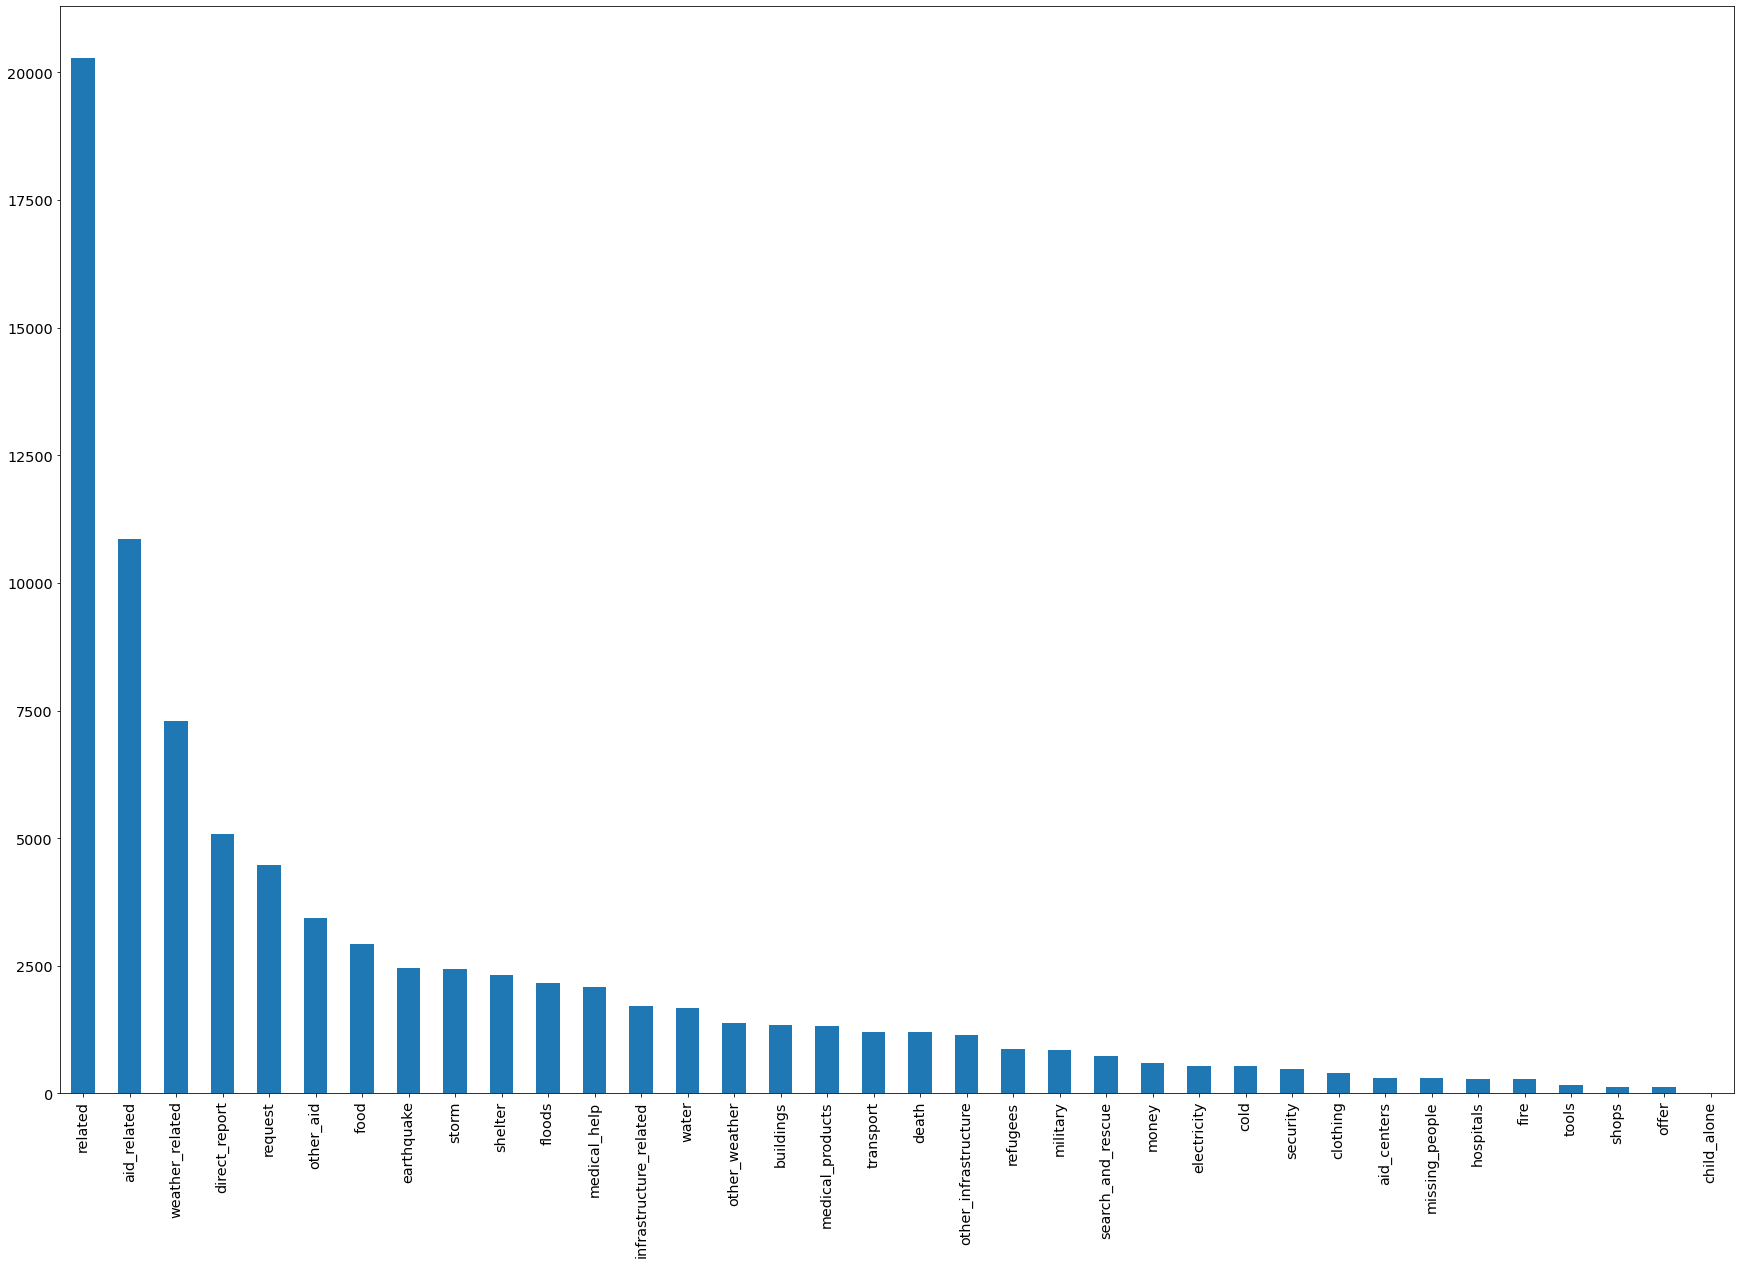

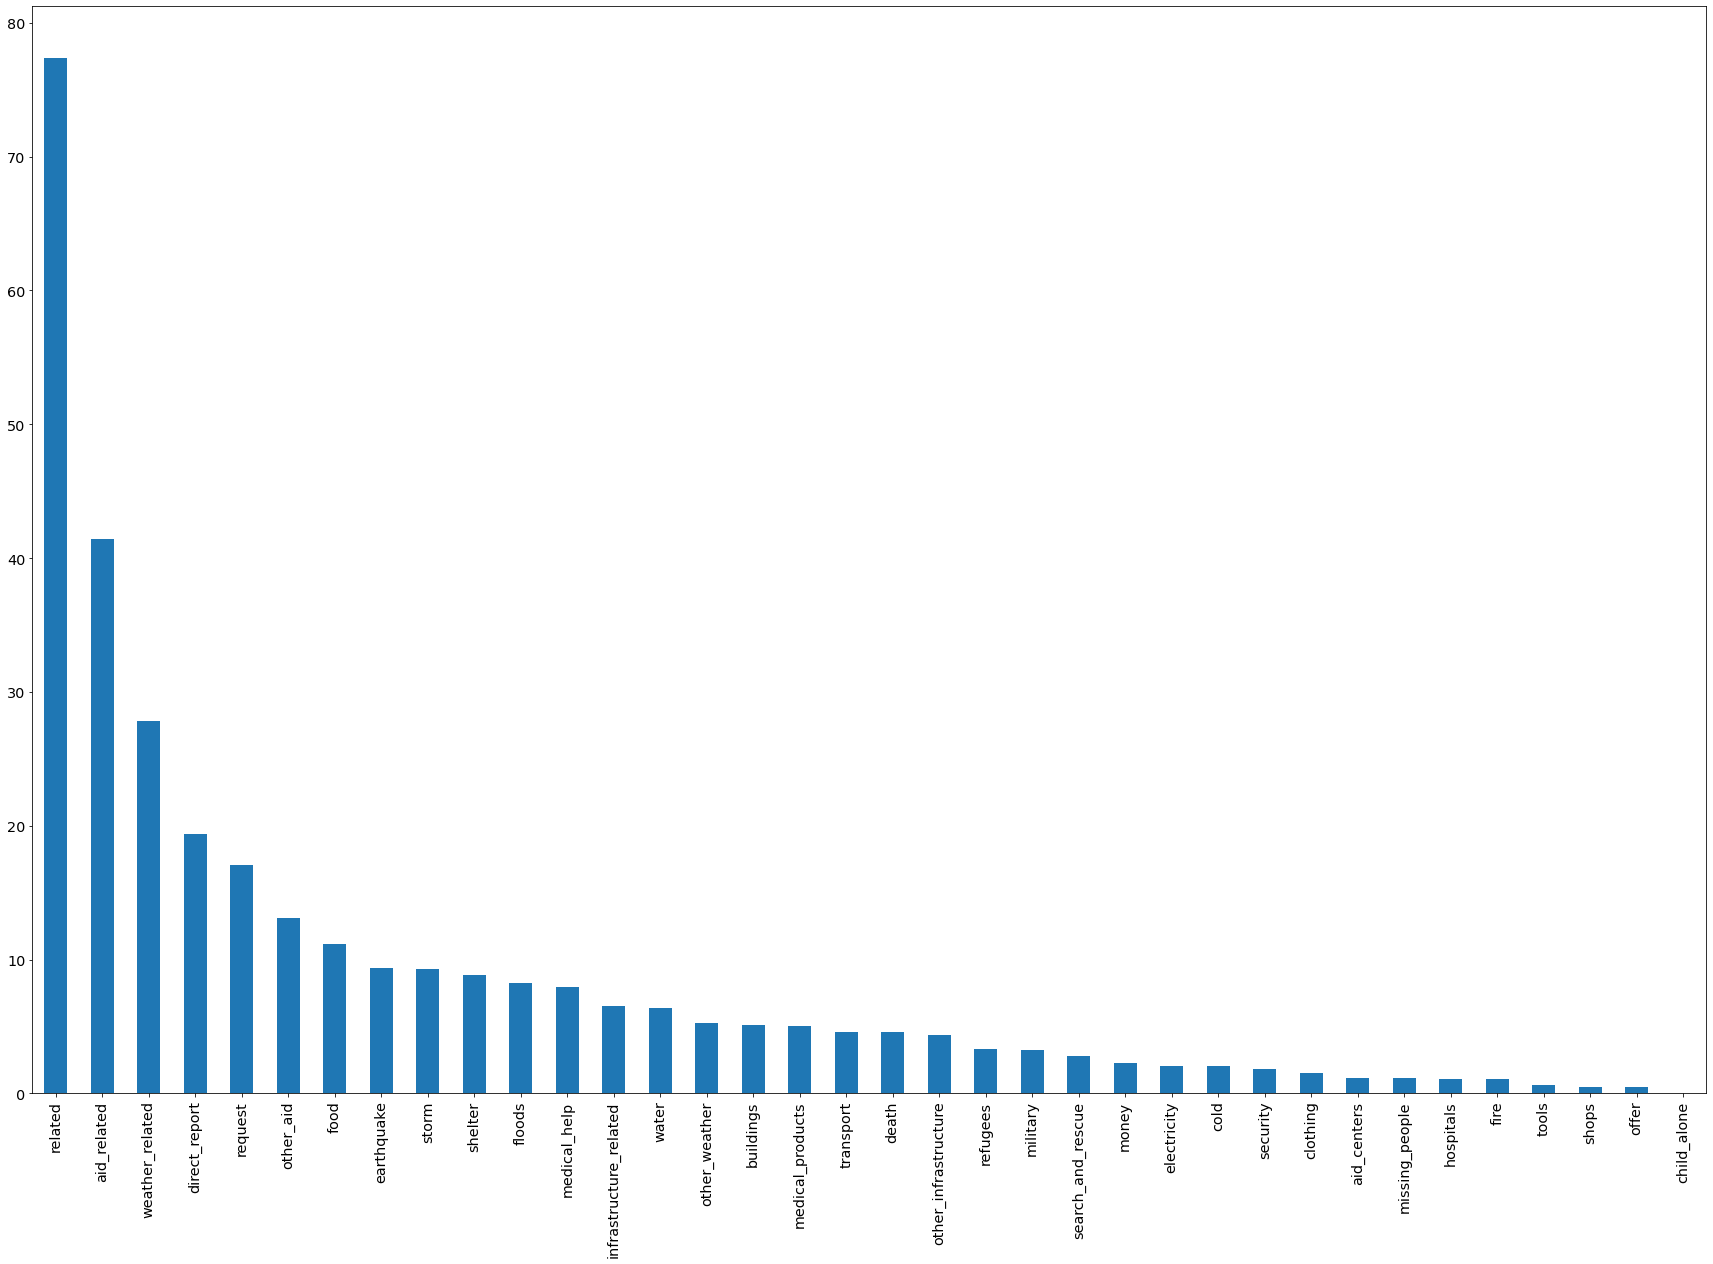

In [56]:
categories = Y.columns.tolist()
occurences = Y.sum()
occurences.sort_values(ascending=False).plot.bar()
plt.show()
occurences_pct = occurences/Y.shape[0]*100
occurences_pct.sort_values(ascending=False).plot.bar()
plt.show()
occurence_target = int(Y.shape[0]/len(categories))
categories_to_upsample = occurences[occurences <= occurence_target].index.tolist()
categories_to_downsample = occurences[occurences > occurence_target].index.tolist()

In [57]:
categories_to_upsample = occurences[occurences <= occurence_target].index.tolist()
categories_to_upsample

['offer',
 'search_and_rescue',
 'security',
 'child_alone',
 'clothing',
 'money',
 'missing_people',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'fire',
 'cold']

In [58]:
categories_to_downsample = occurences[occurences > occurence_target].index.tolist()
categories_to_downsample

['related',
 'request',
 'aid_related',
 'medical_help',
 'medical_products',
 'military',
 'water',
 'food',
 'shelter',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'earthquake',
 'other_weather',
 'direct_report']

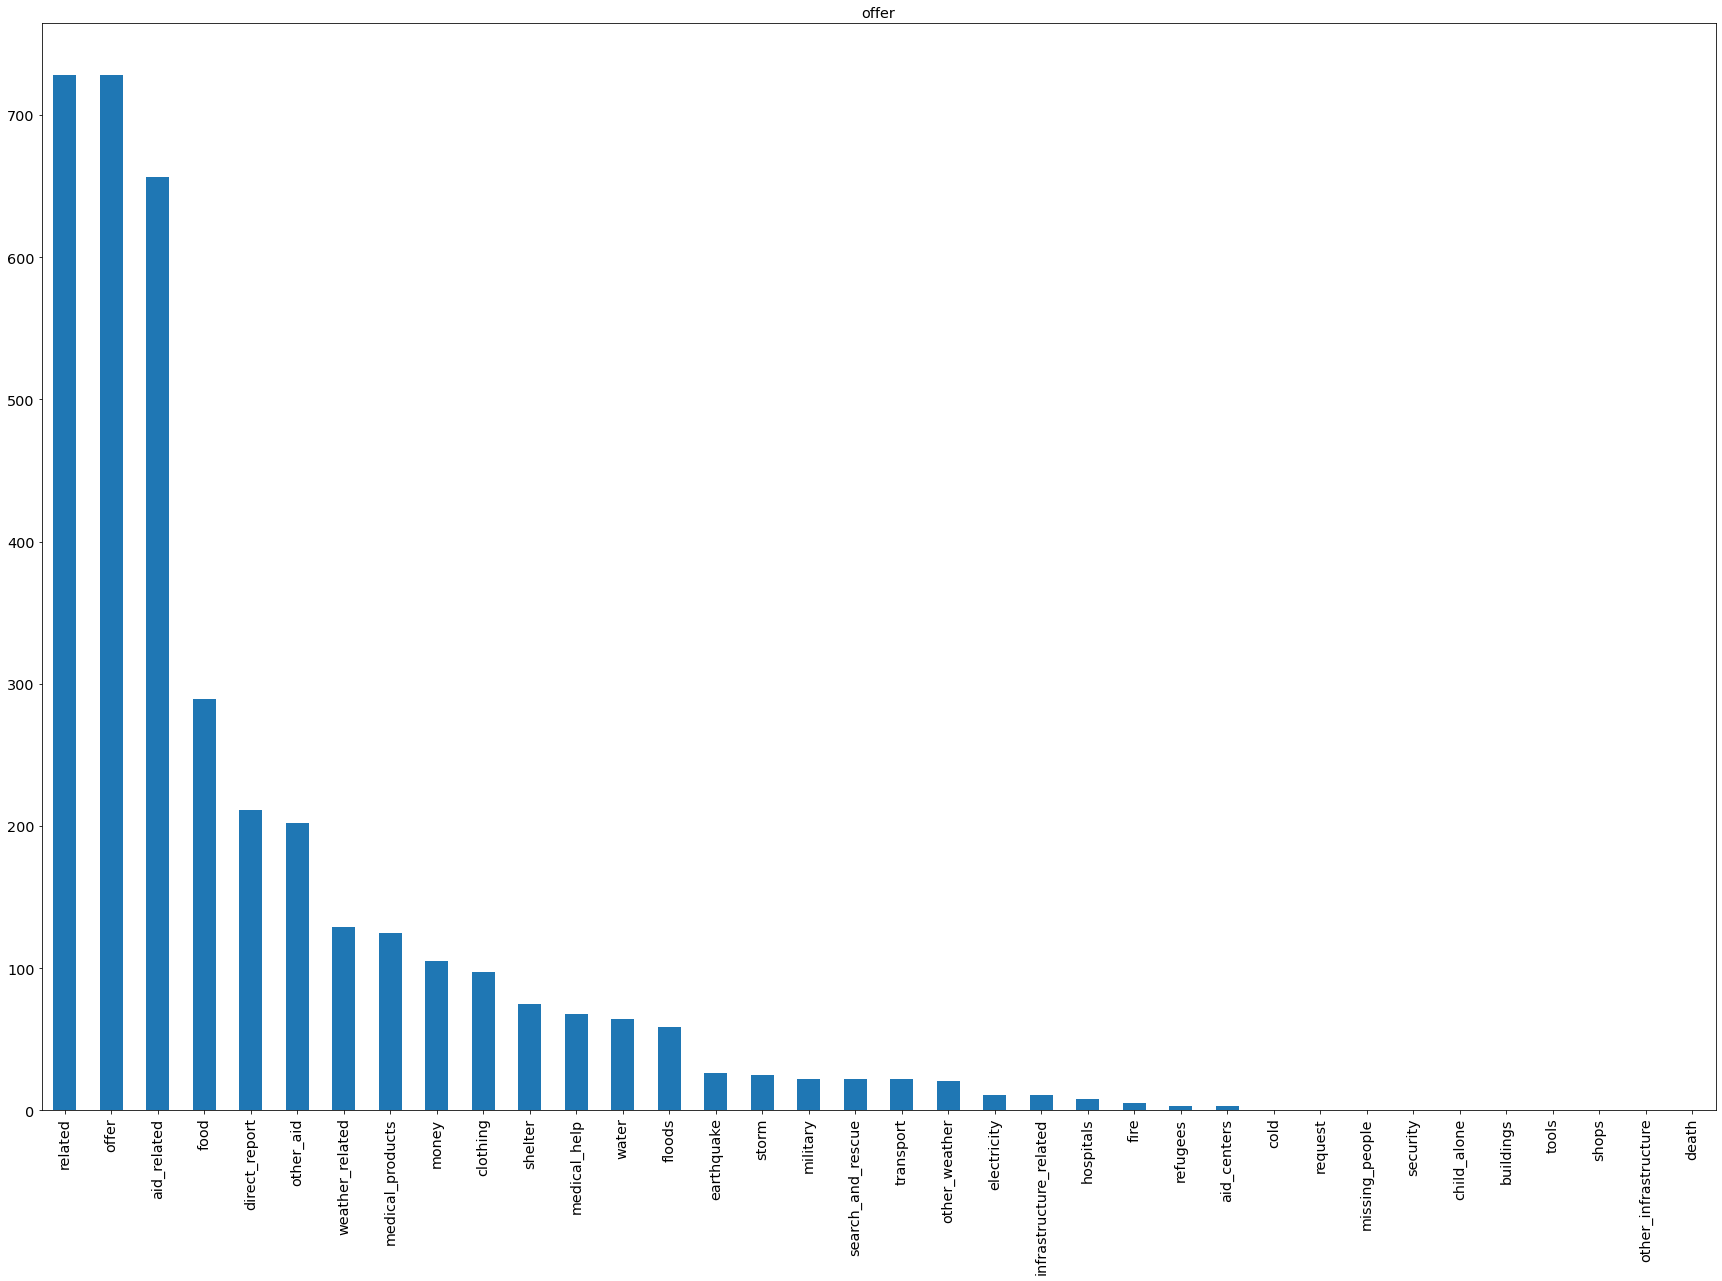

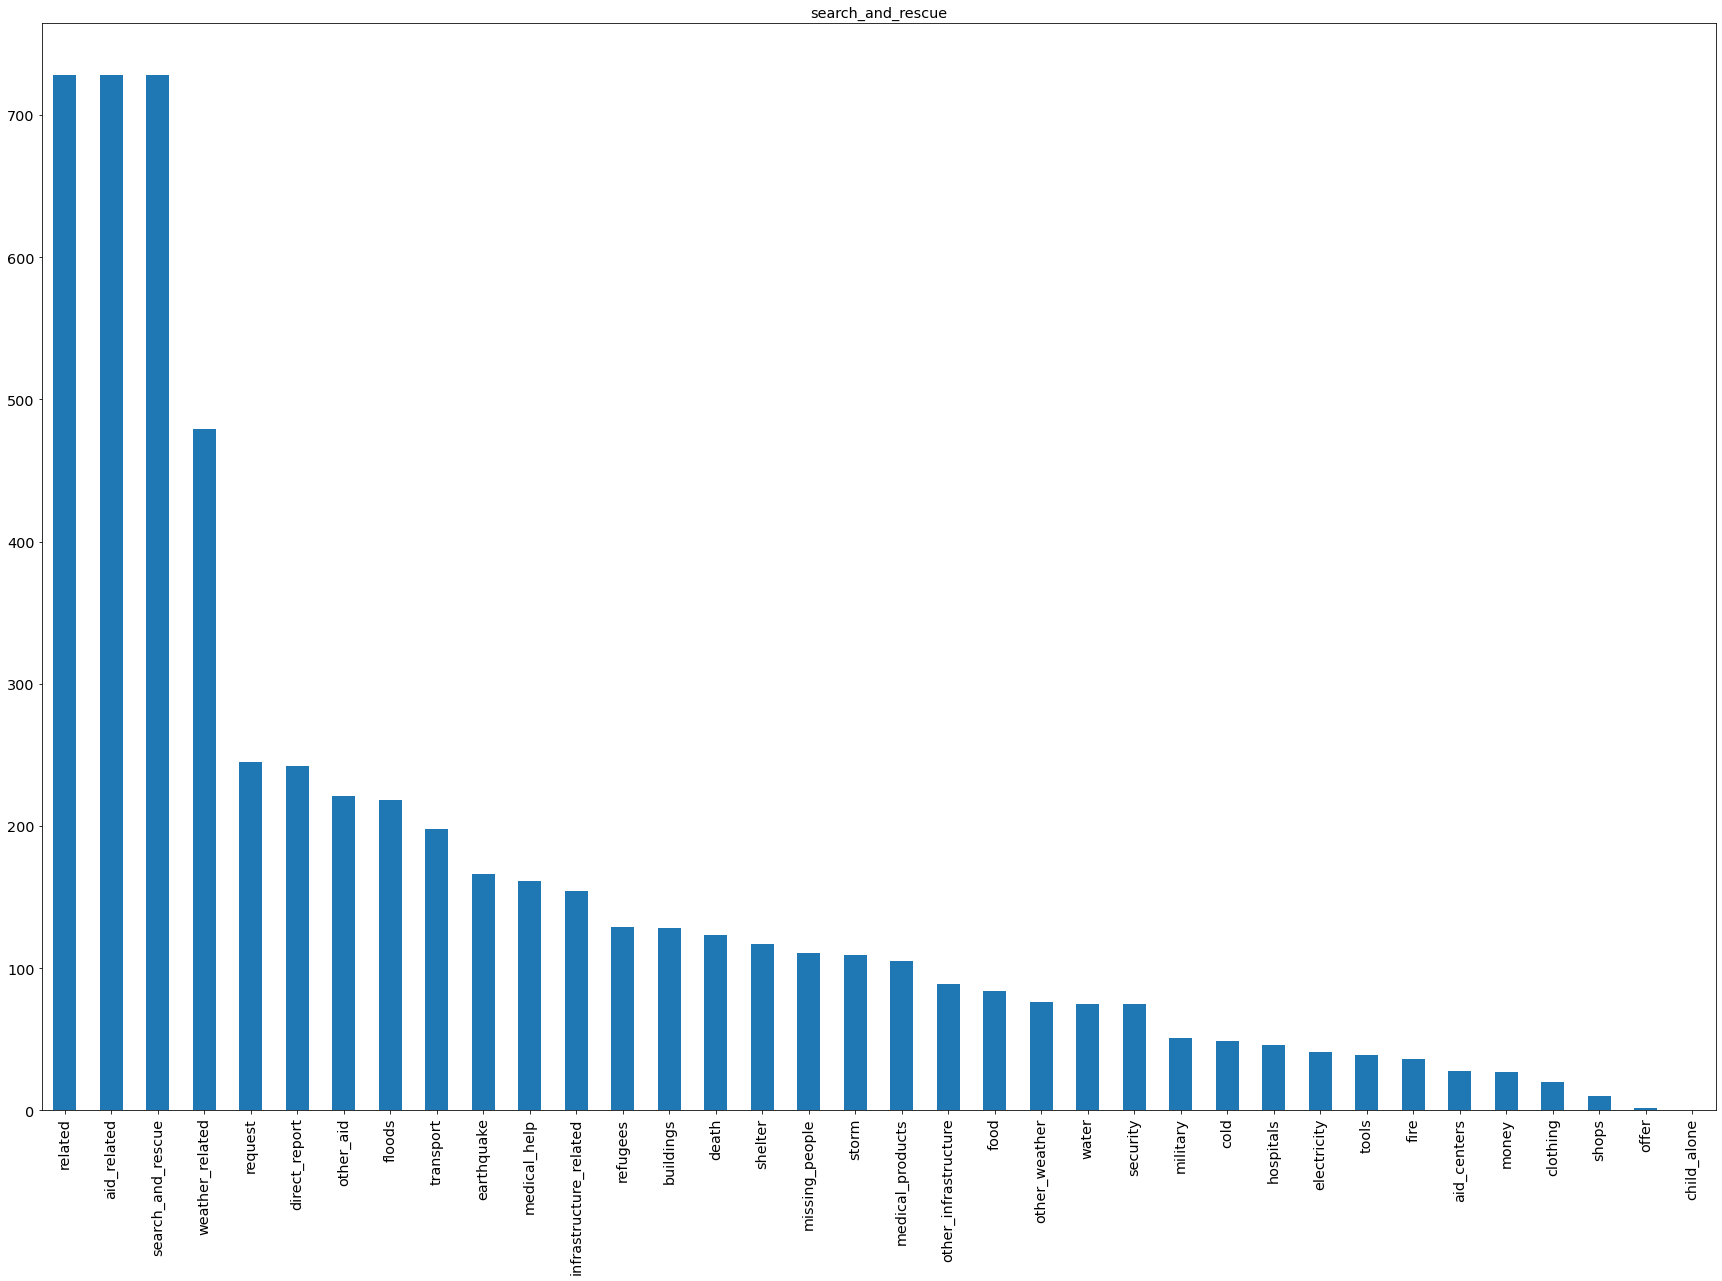

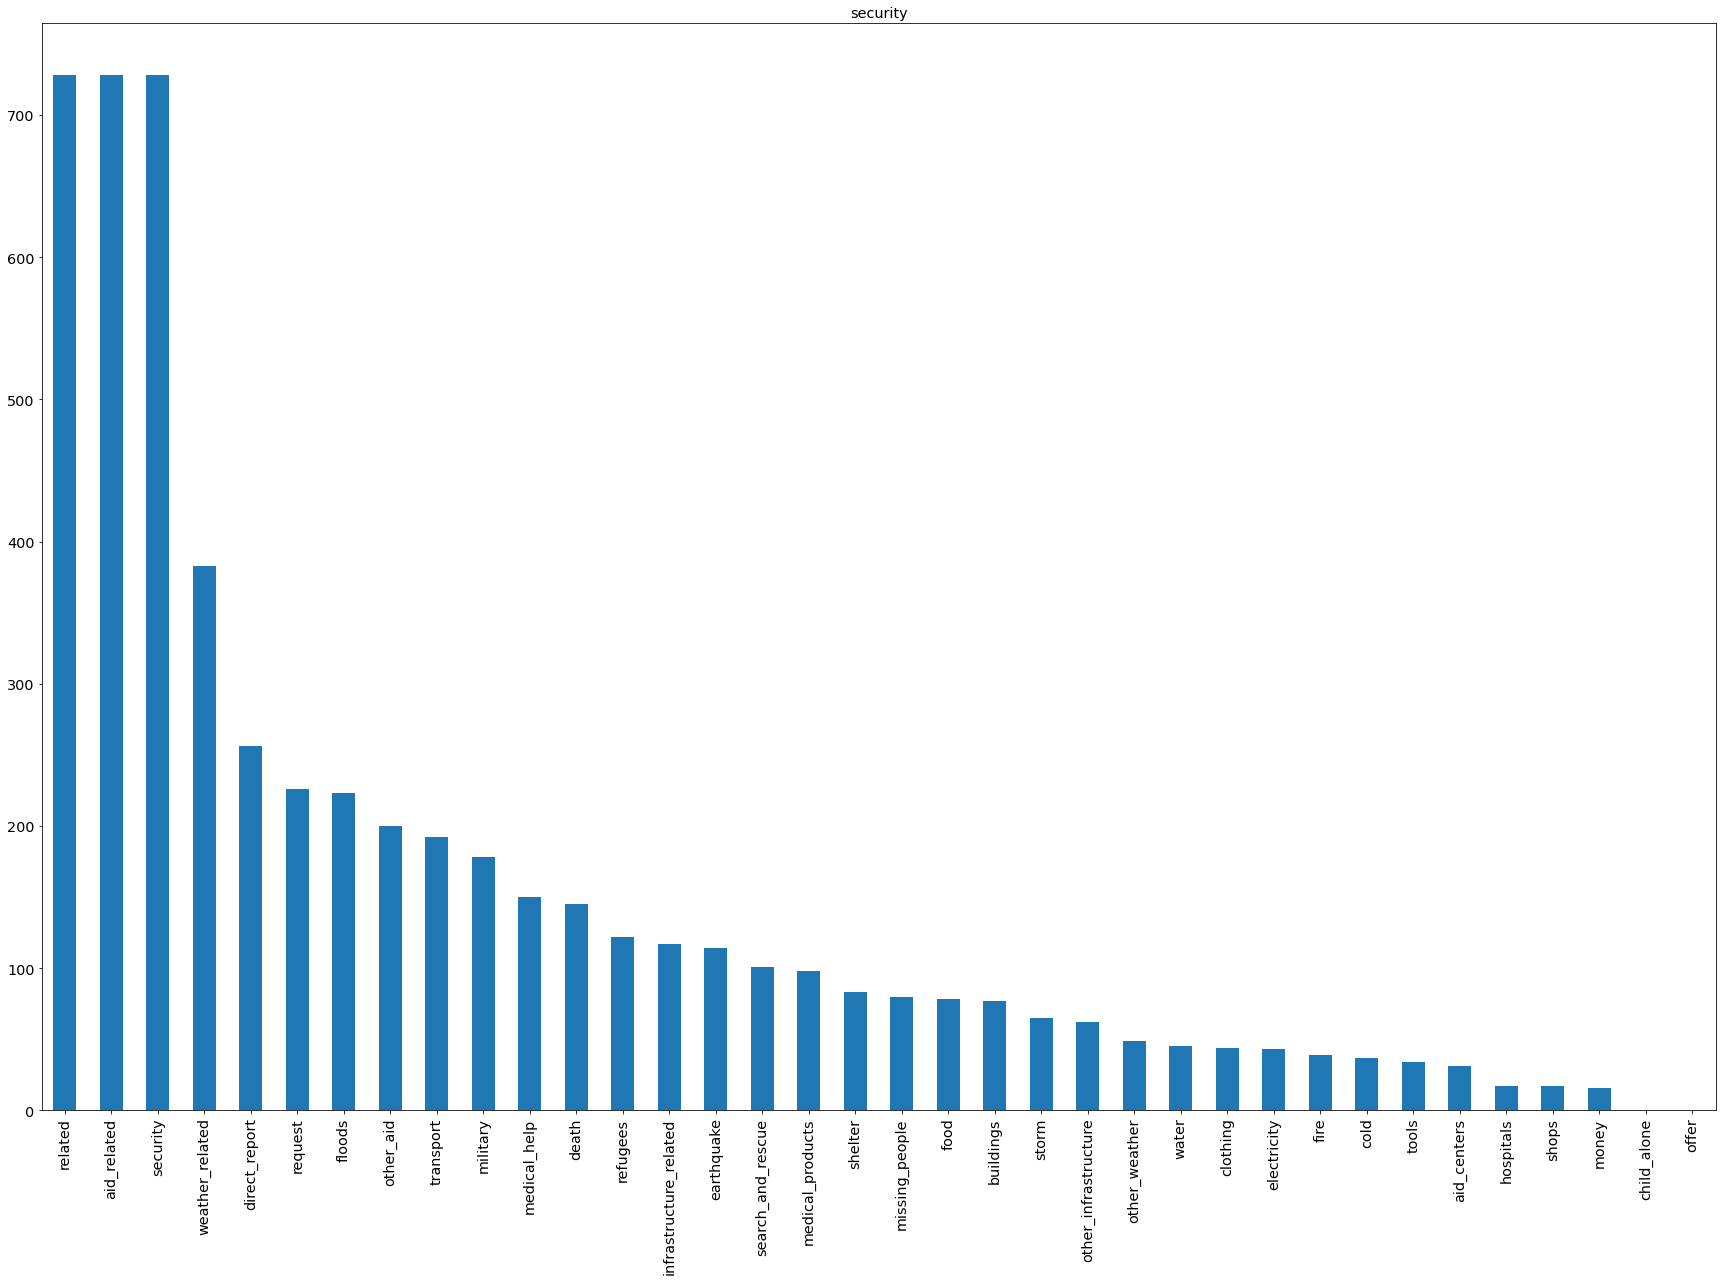

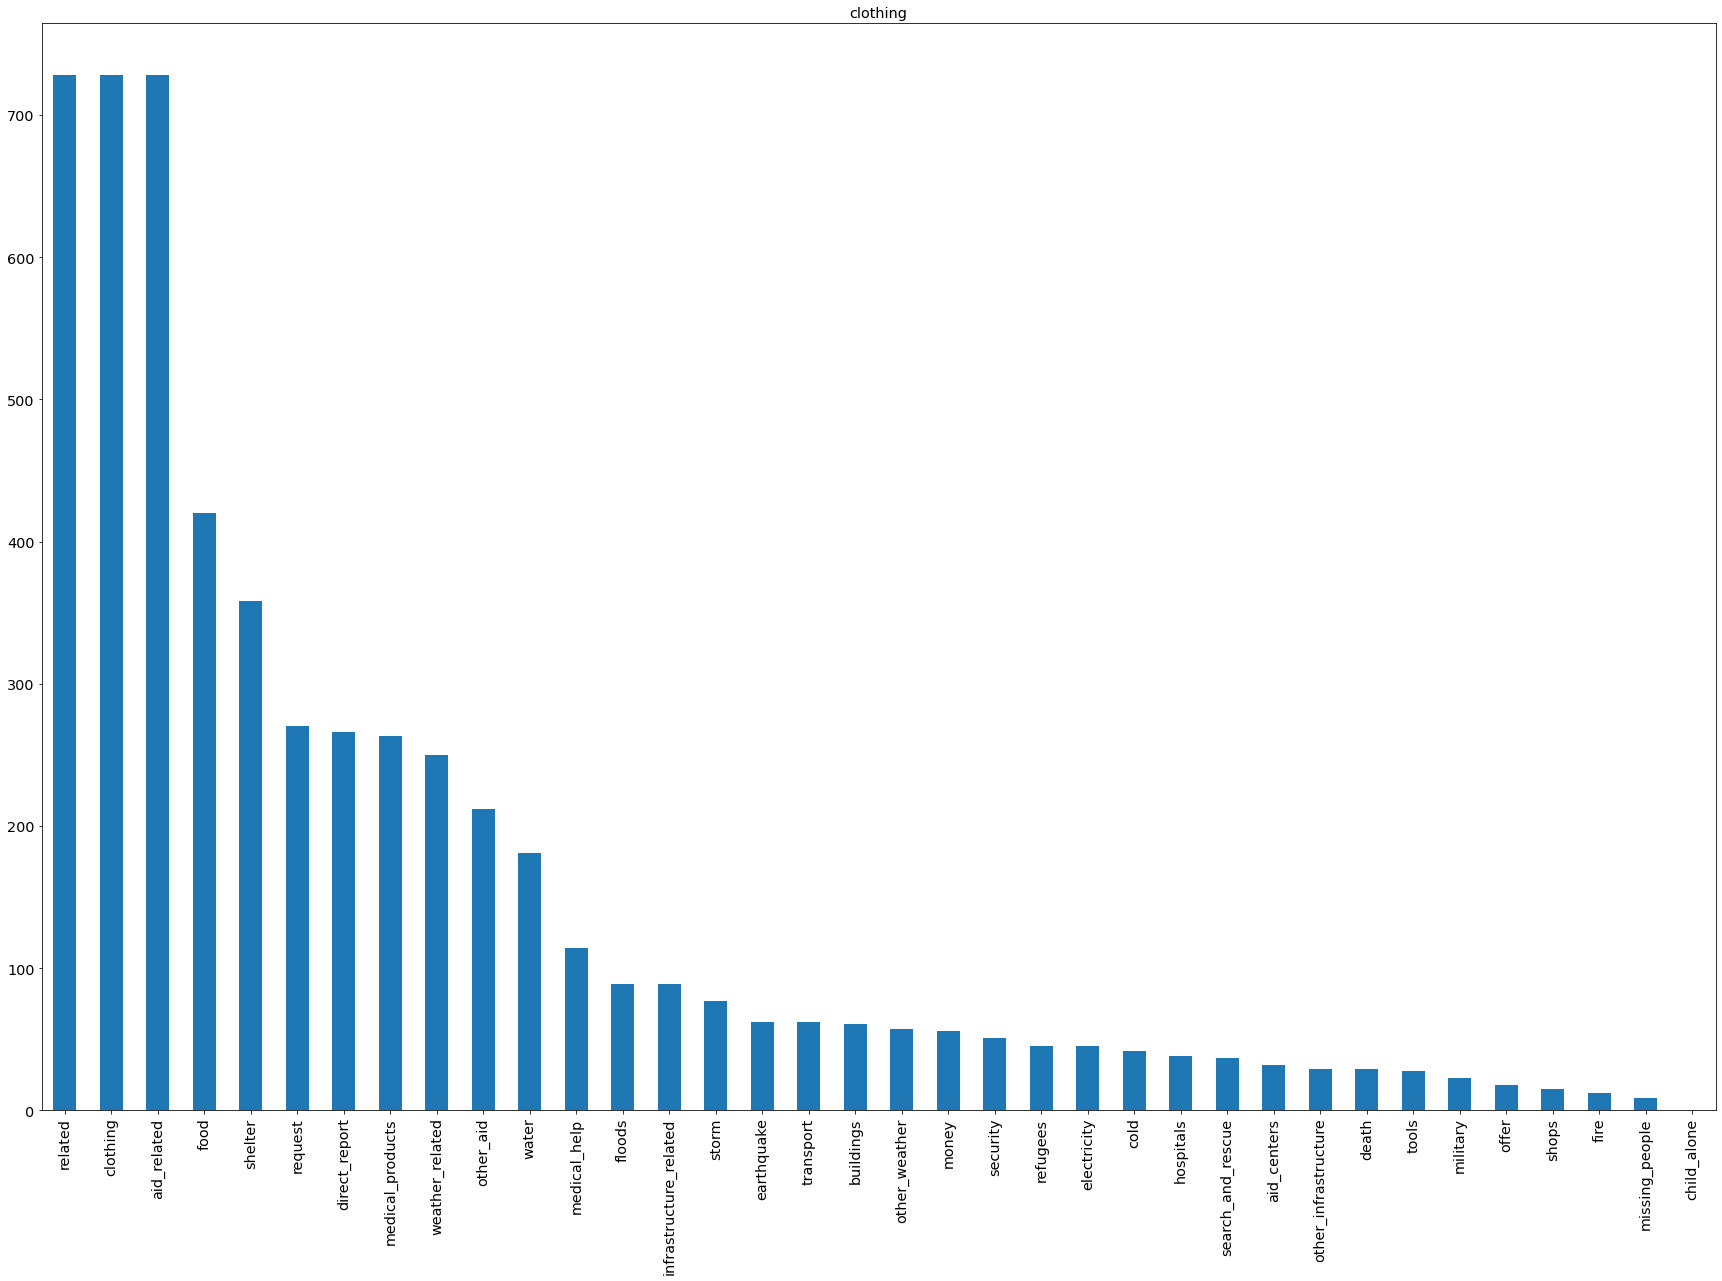

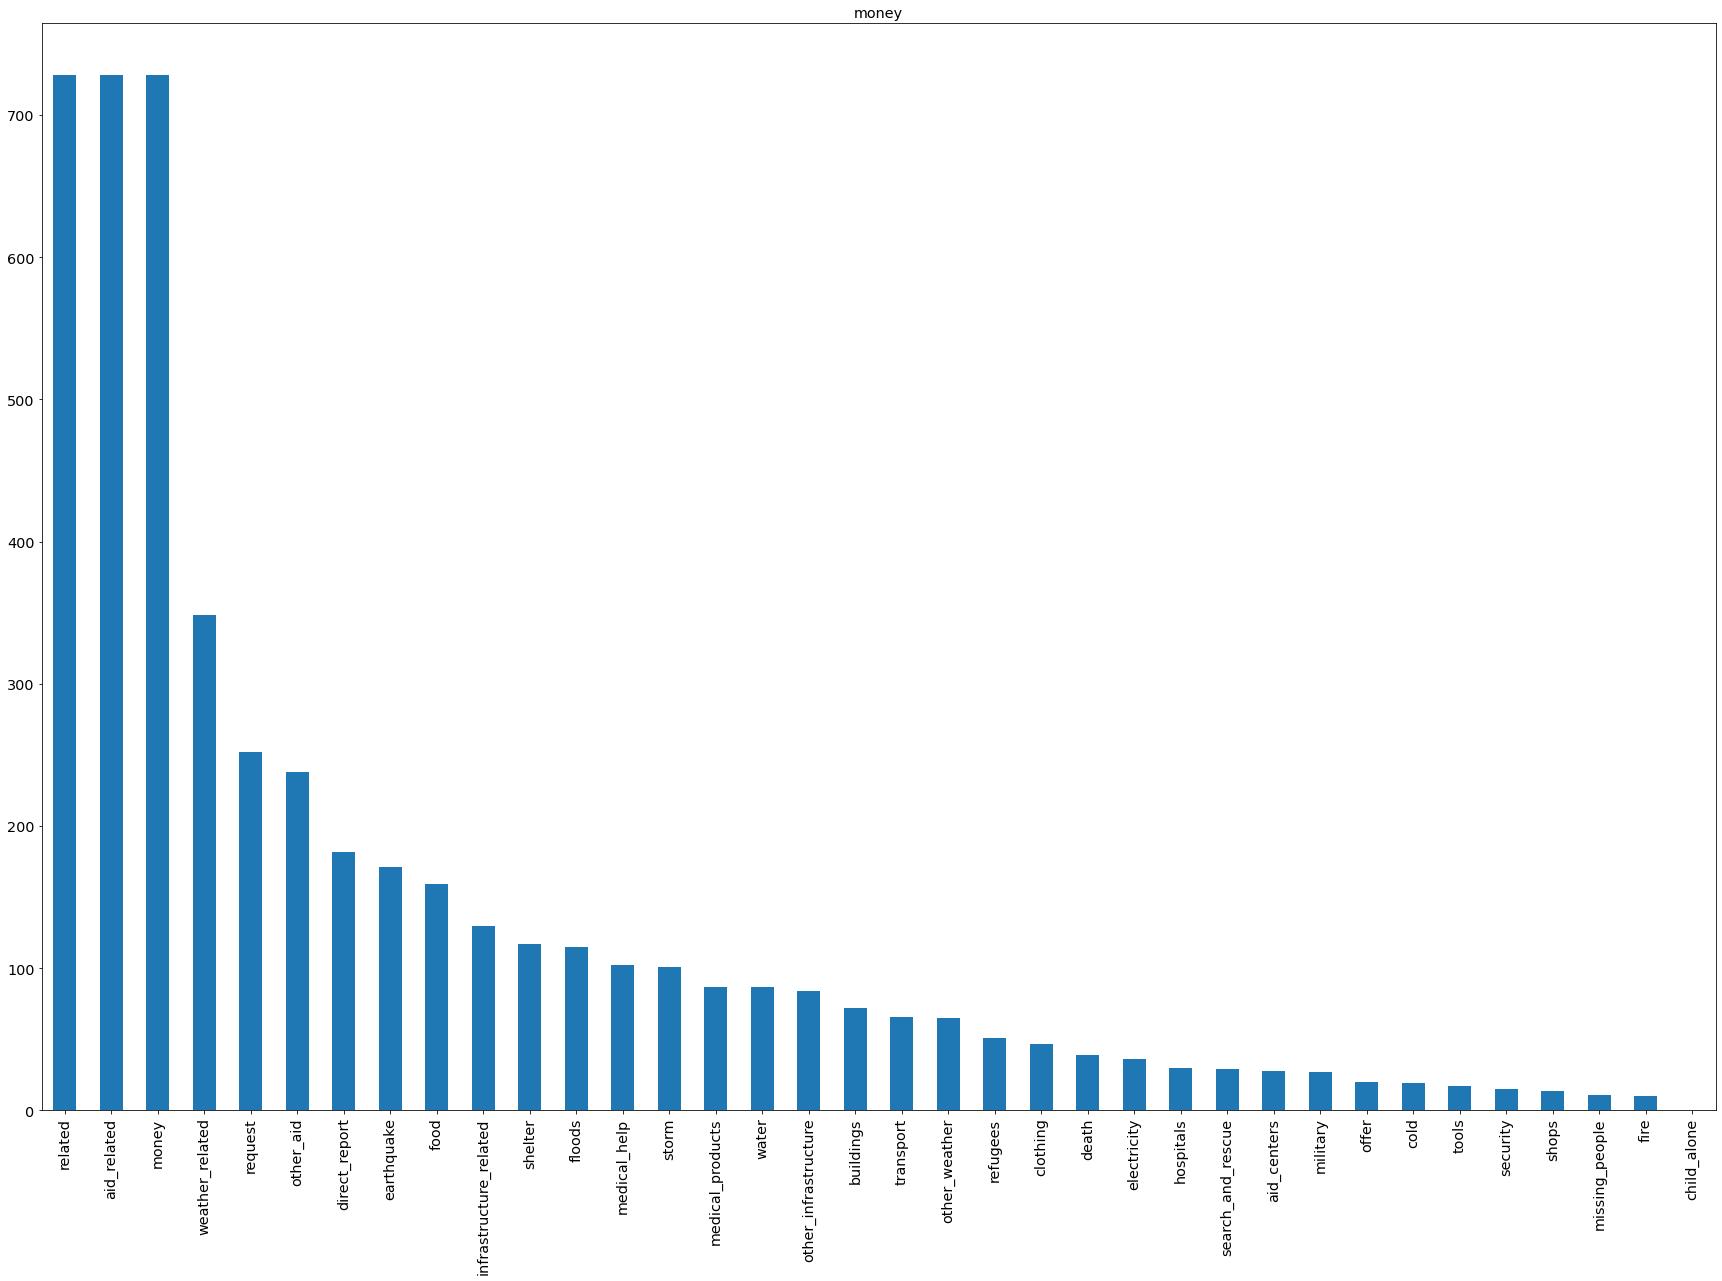

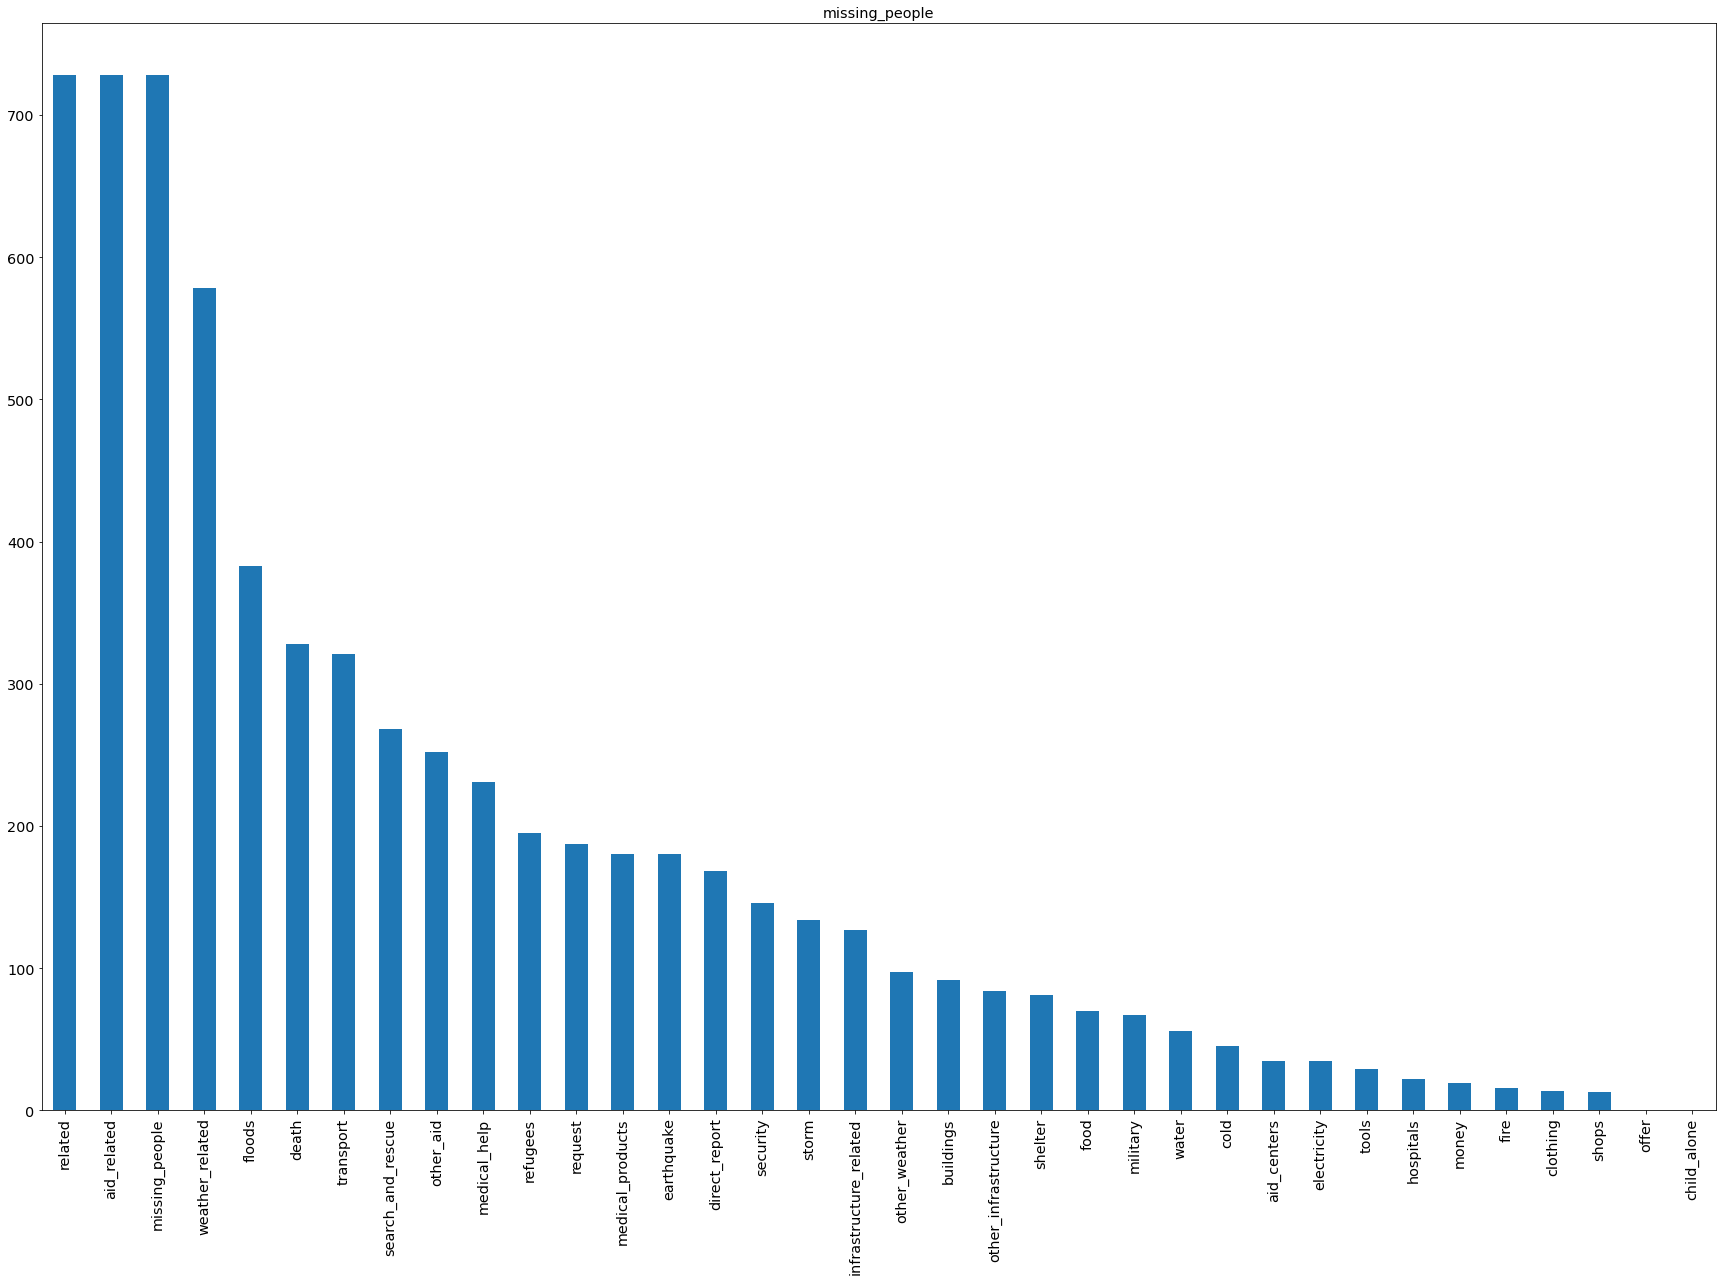

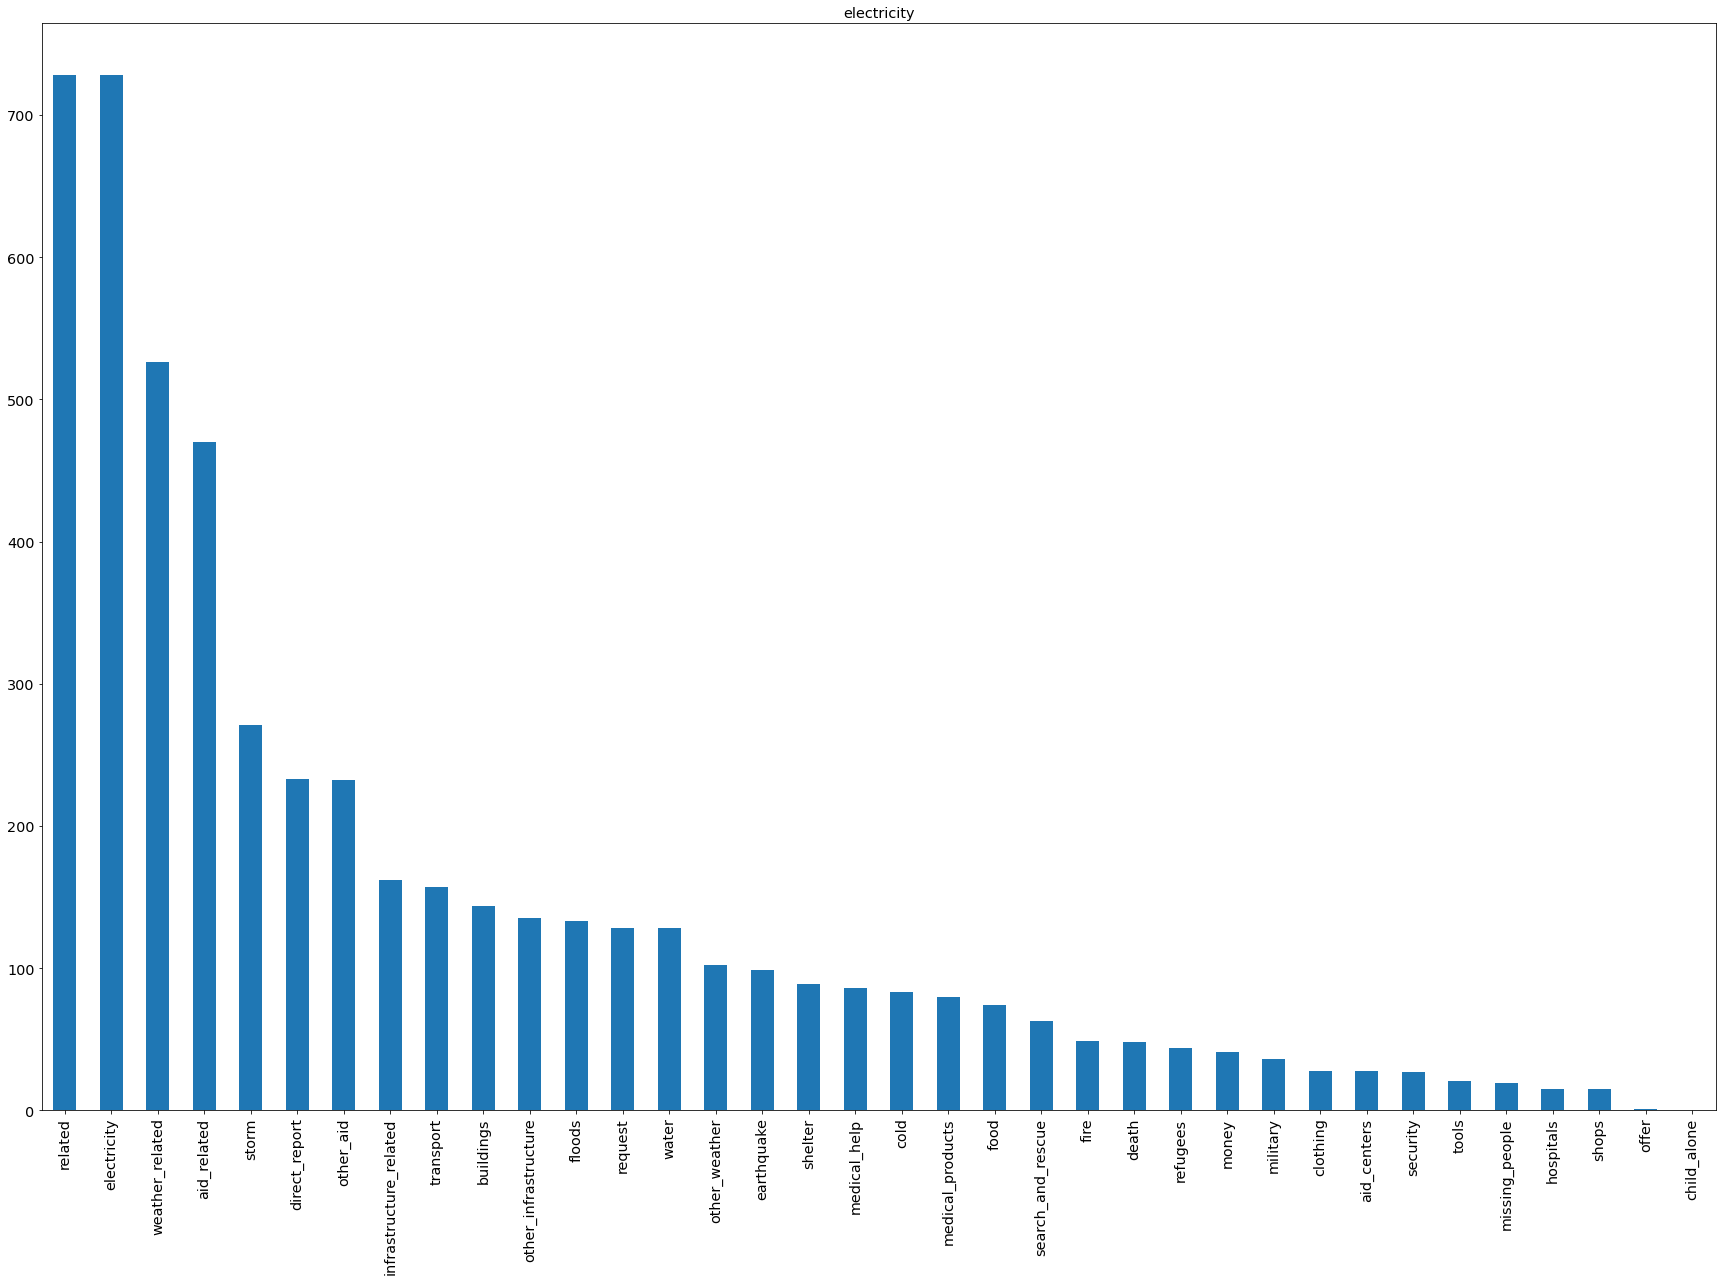

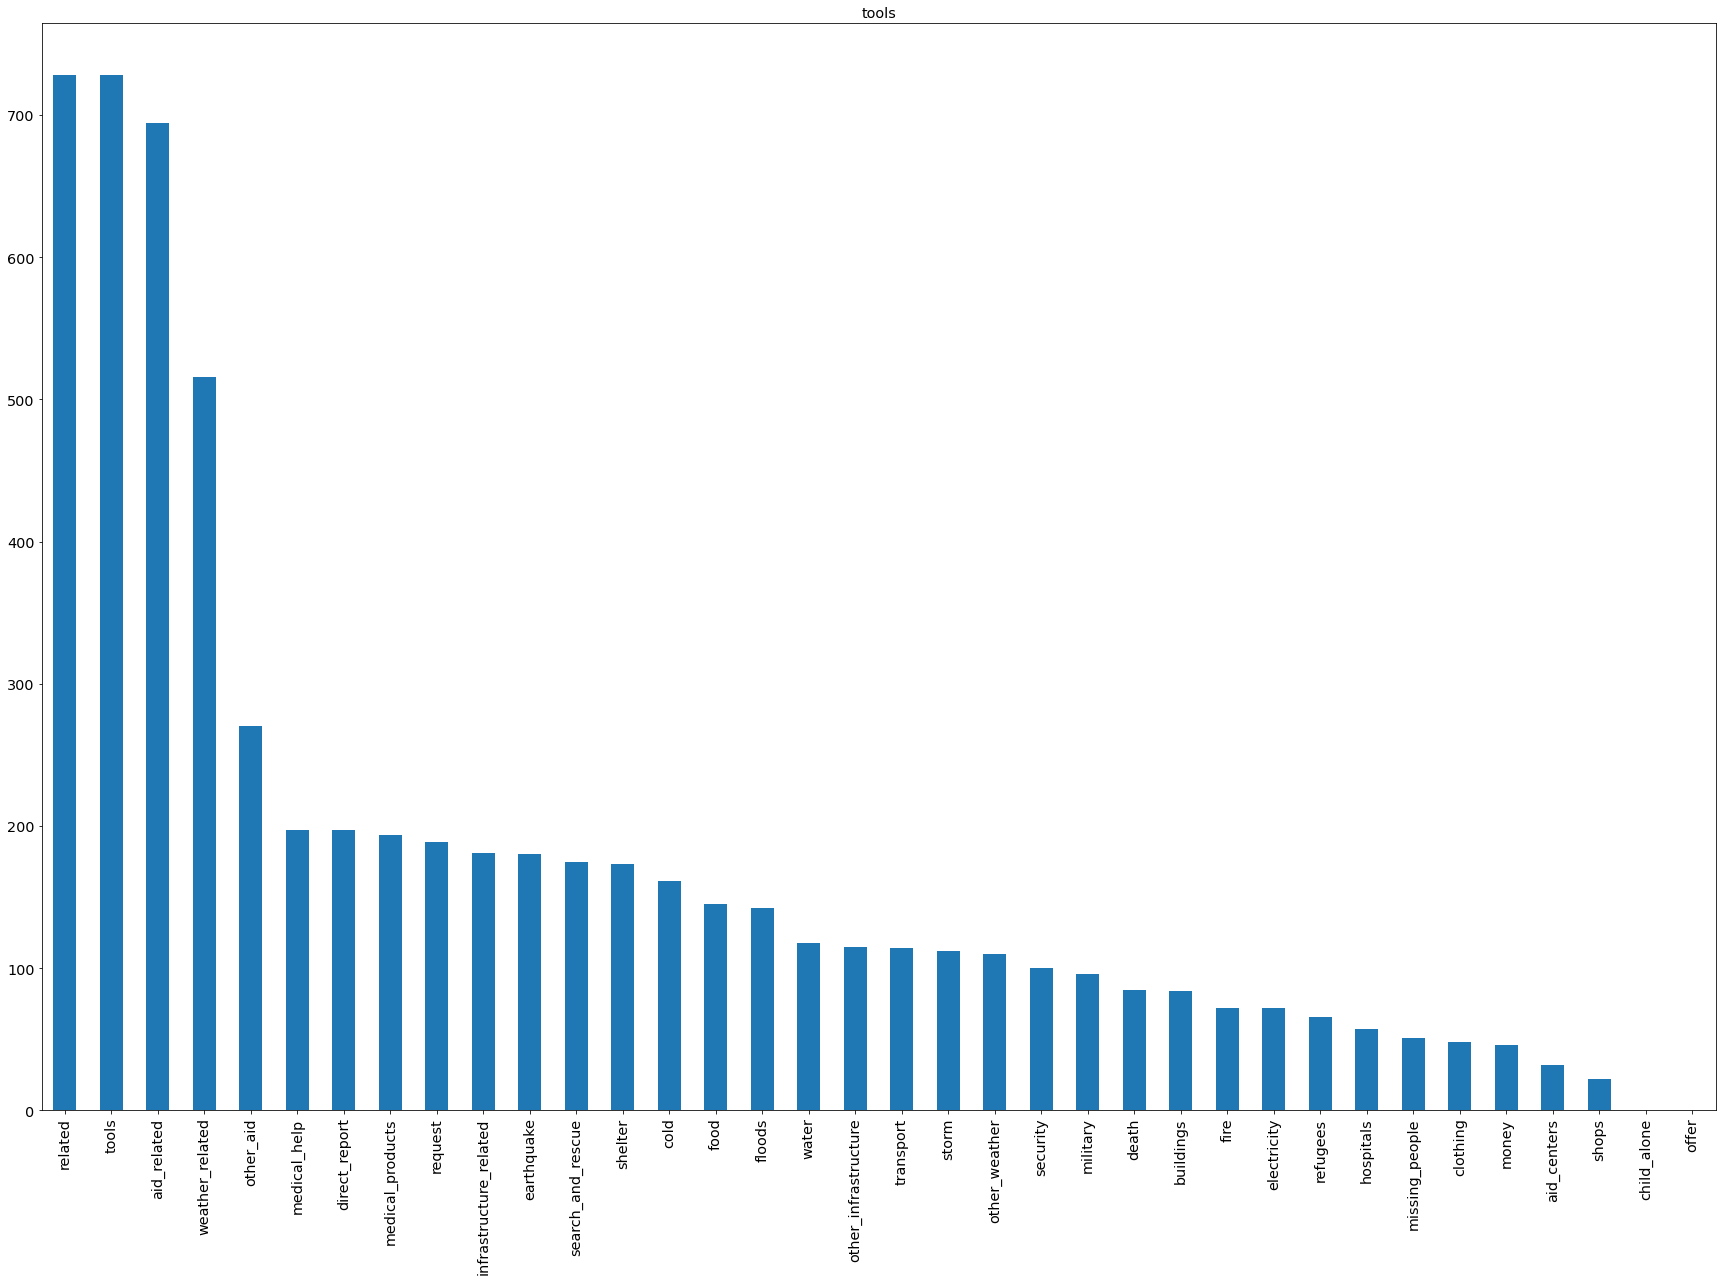

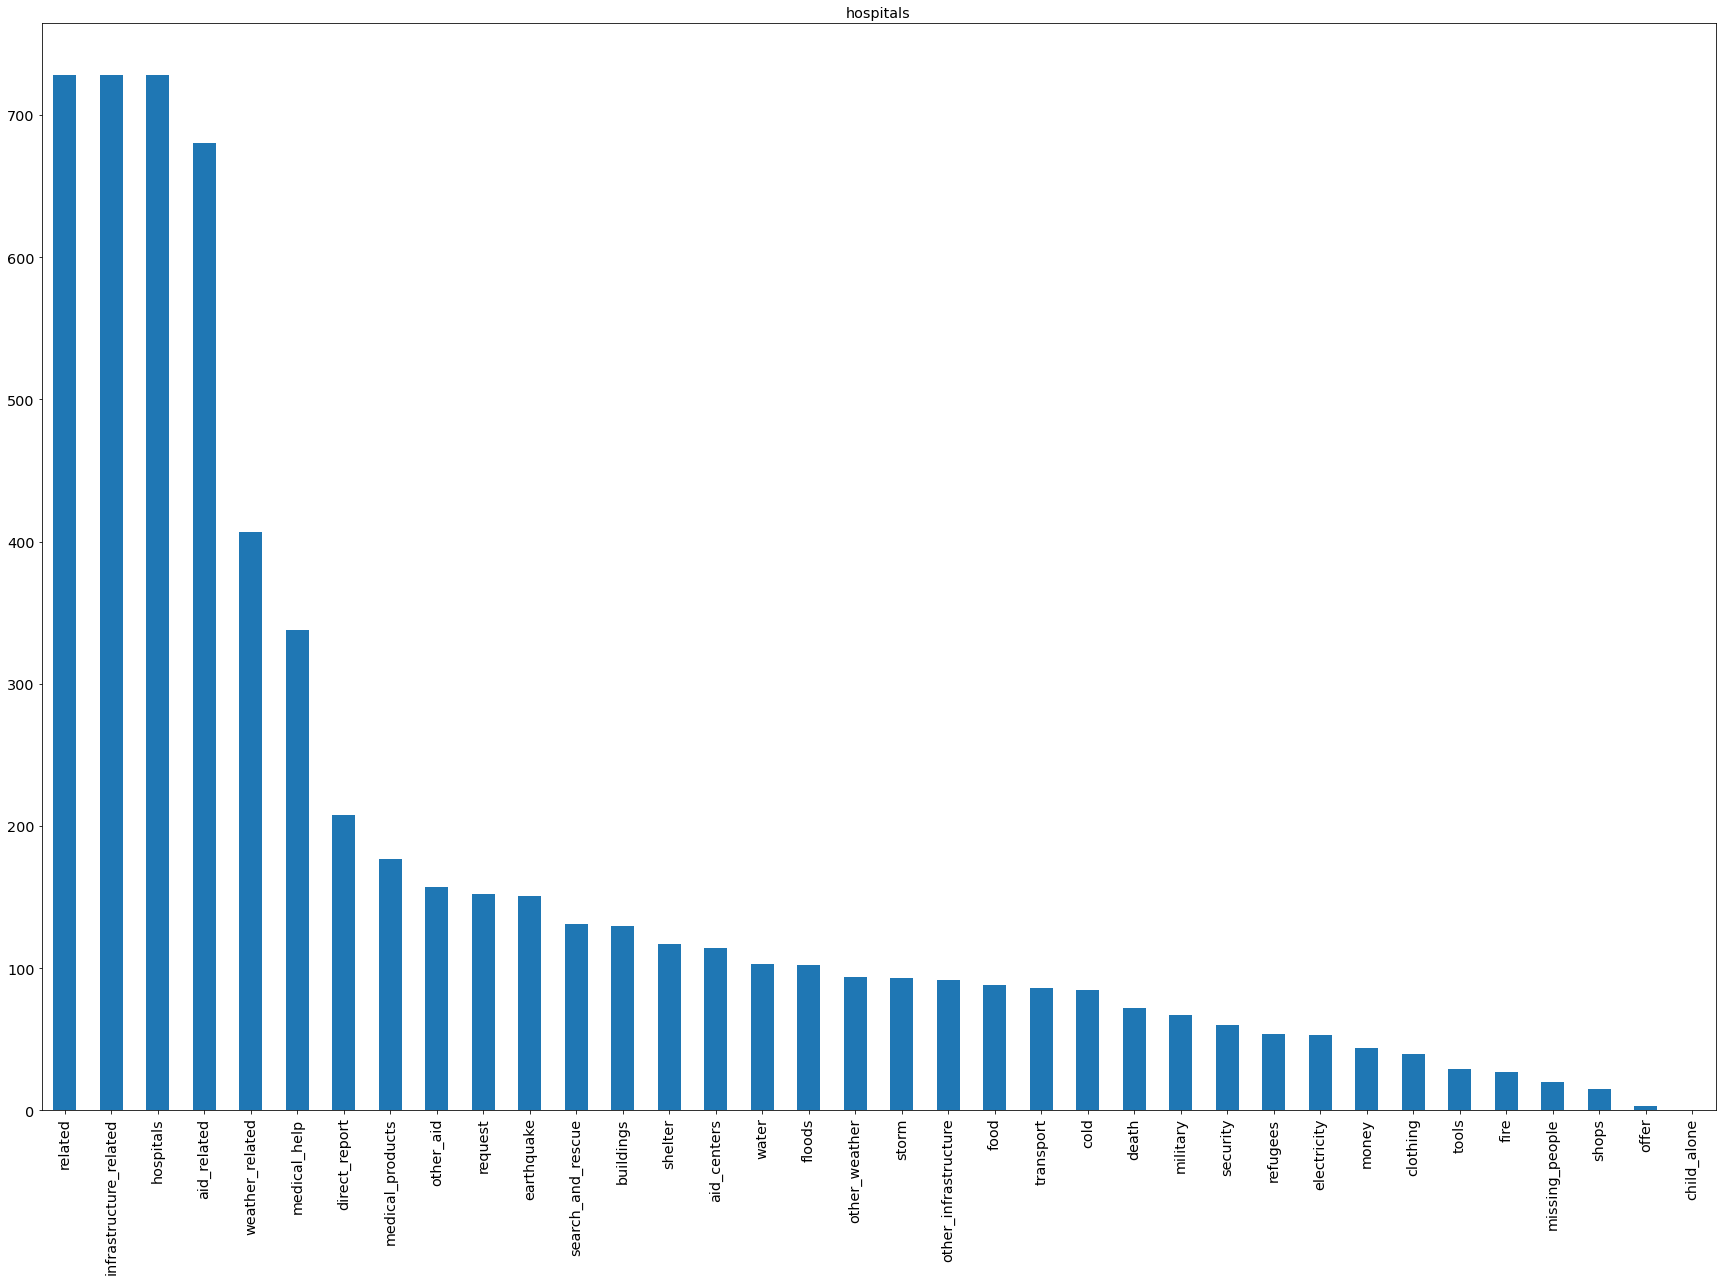

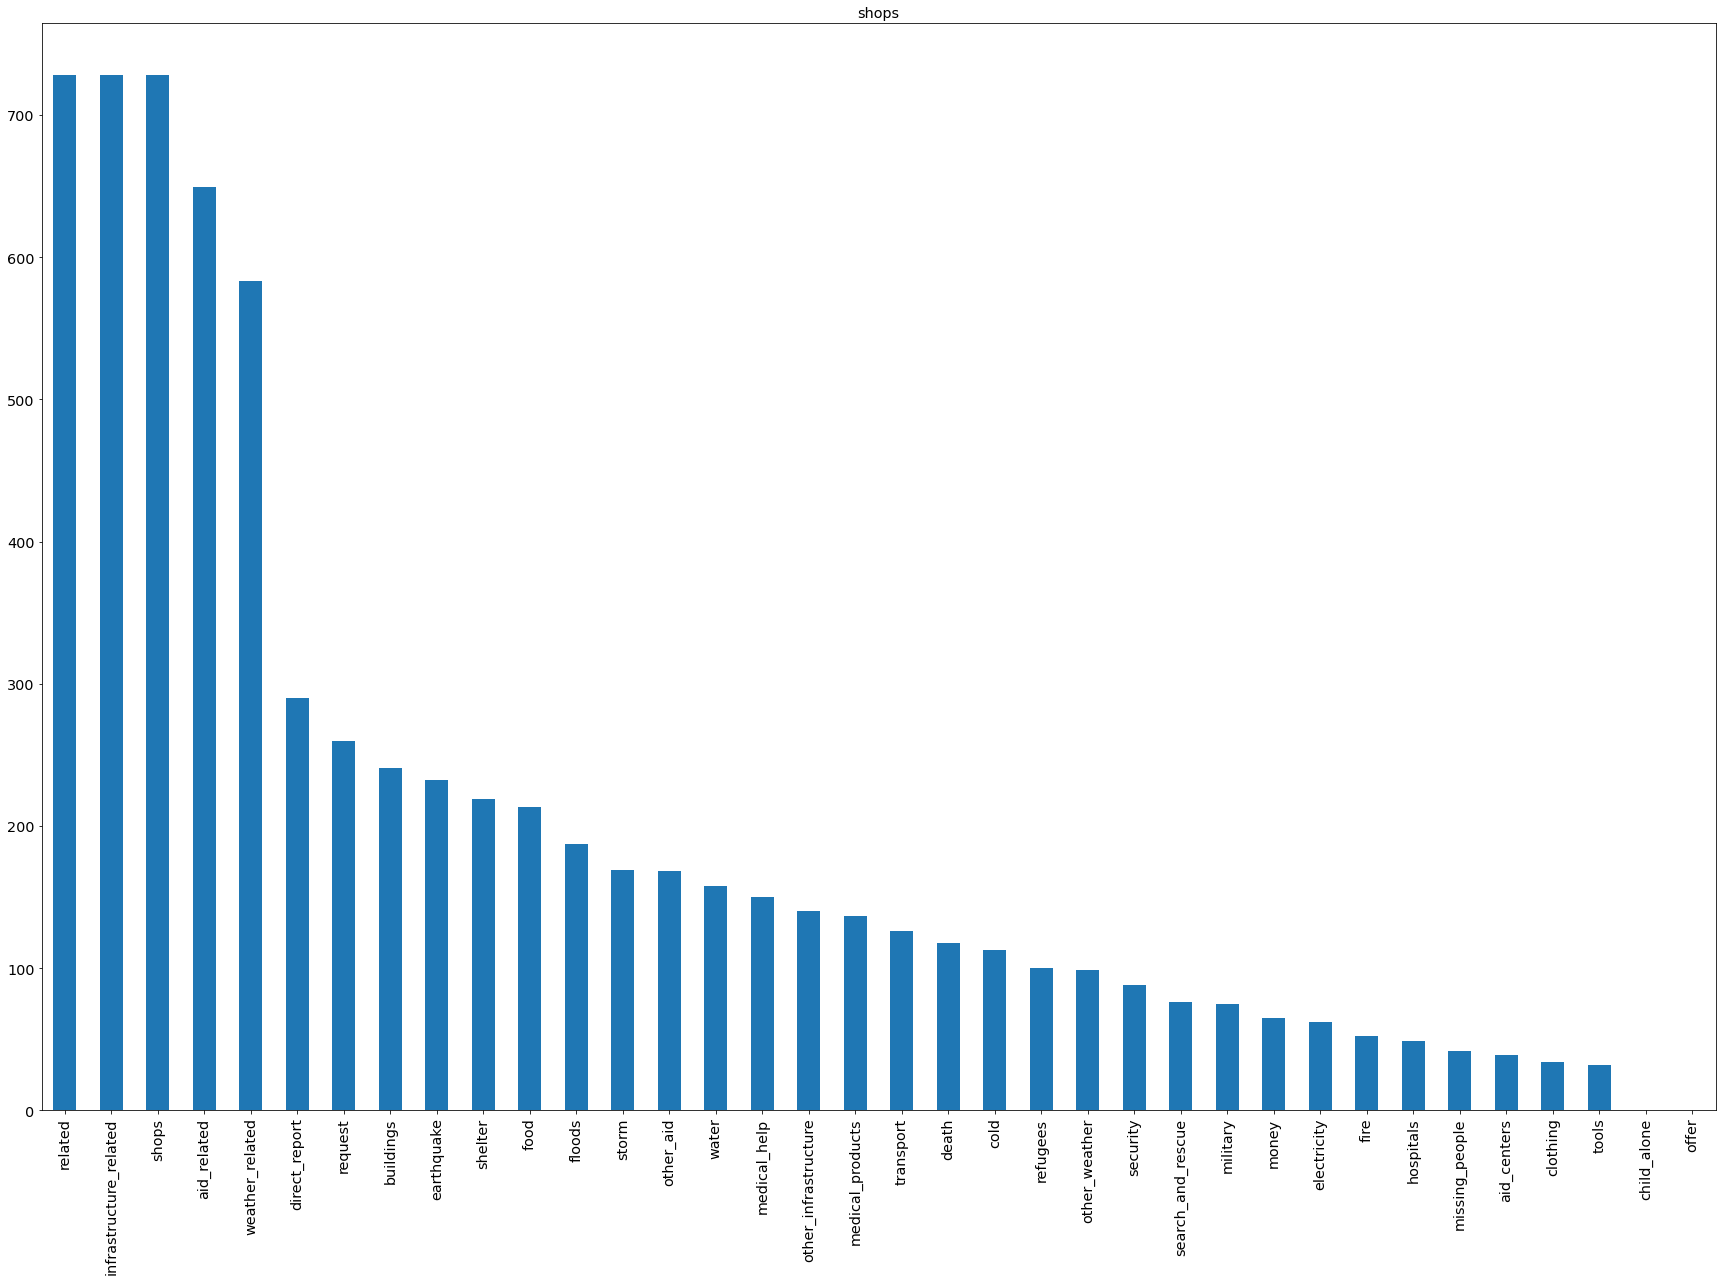

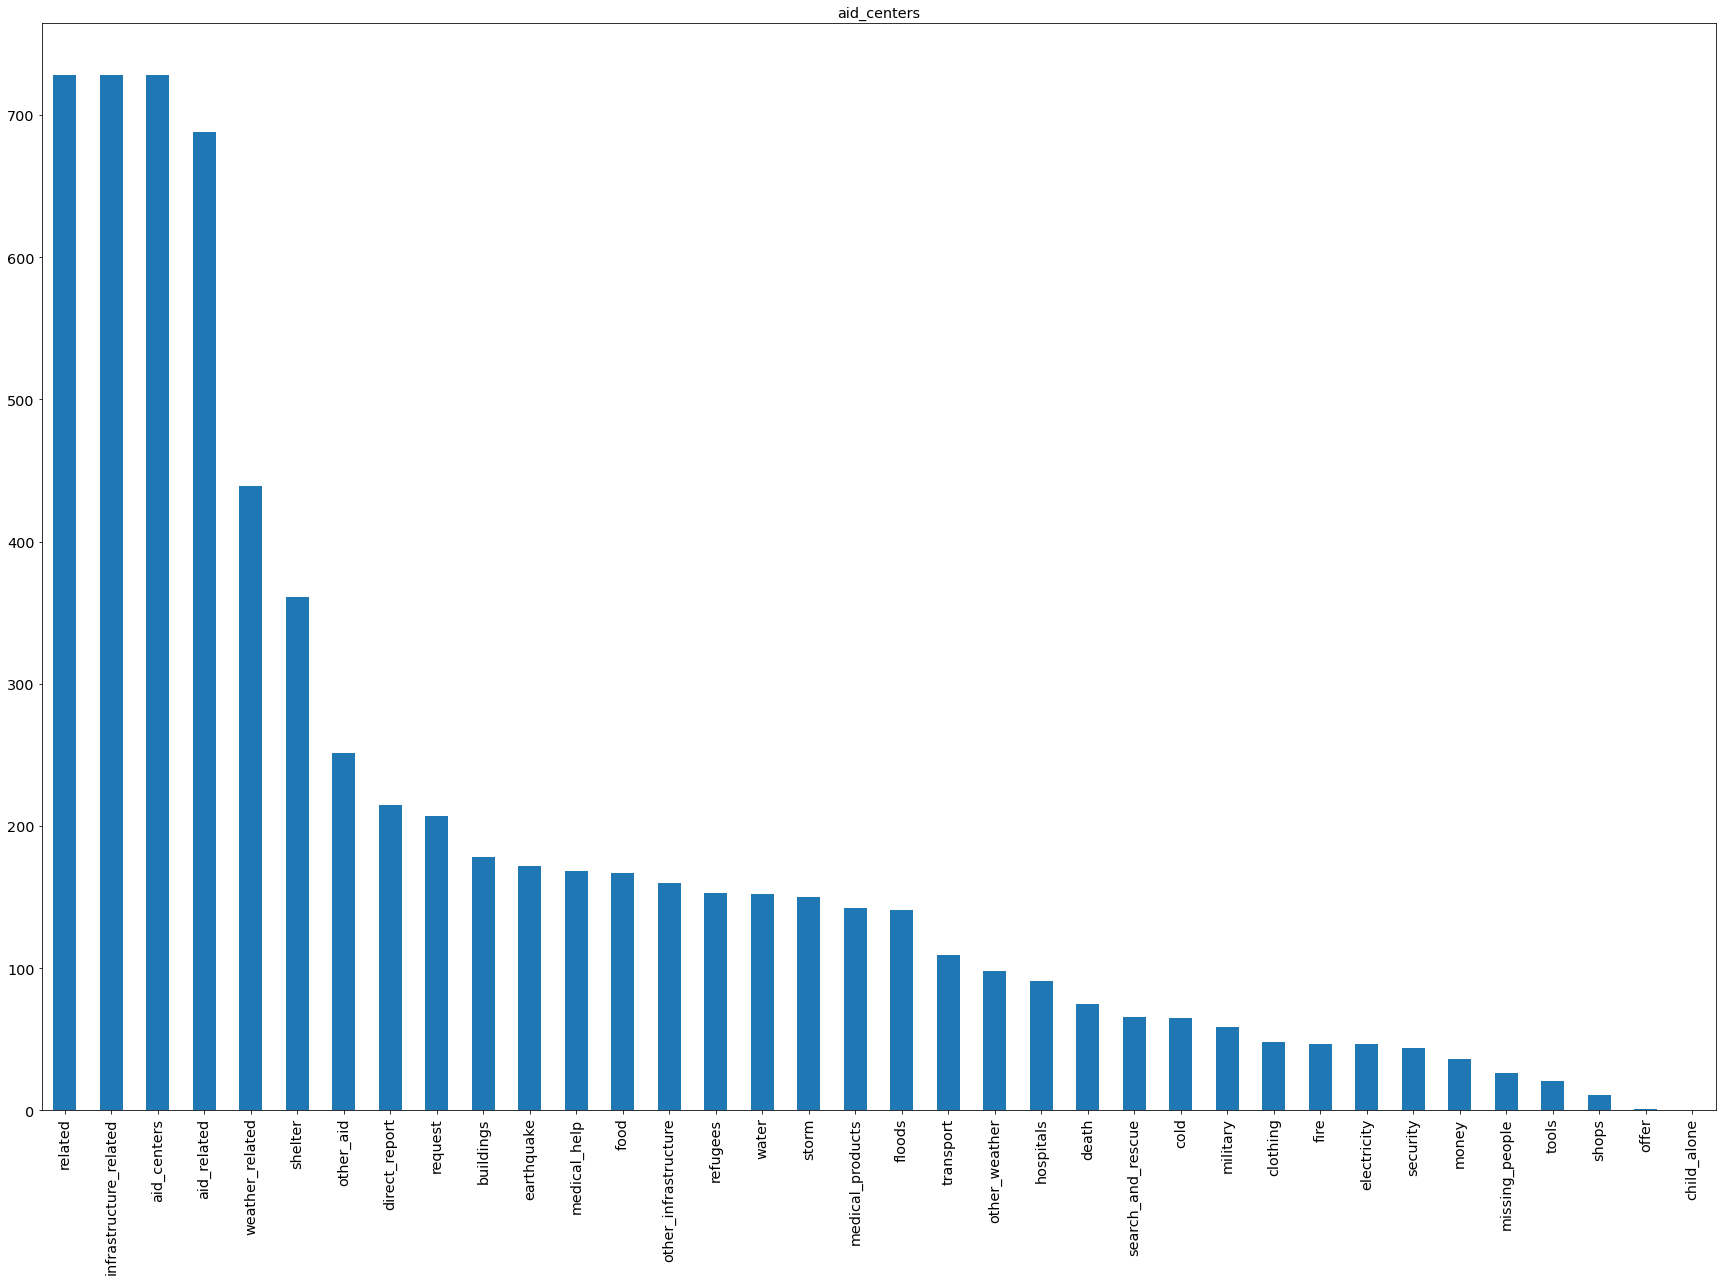

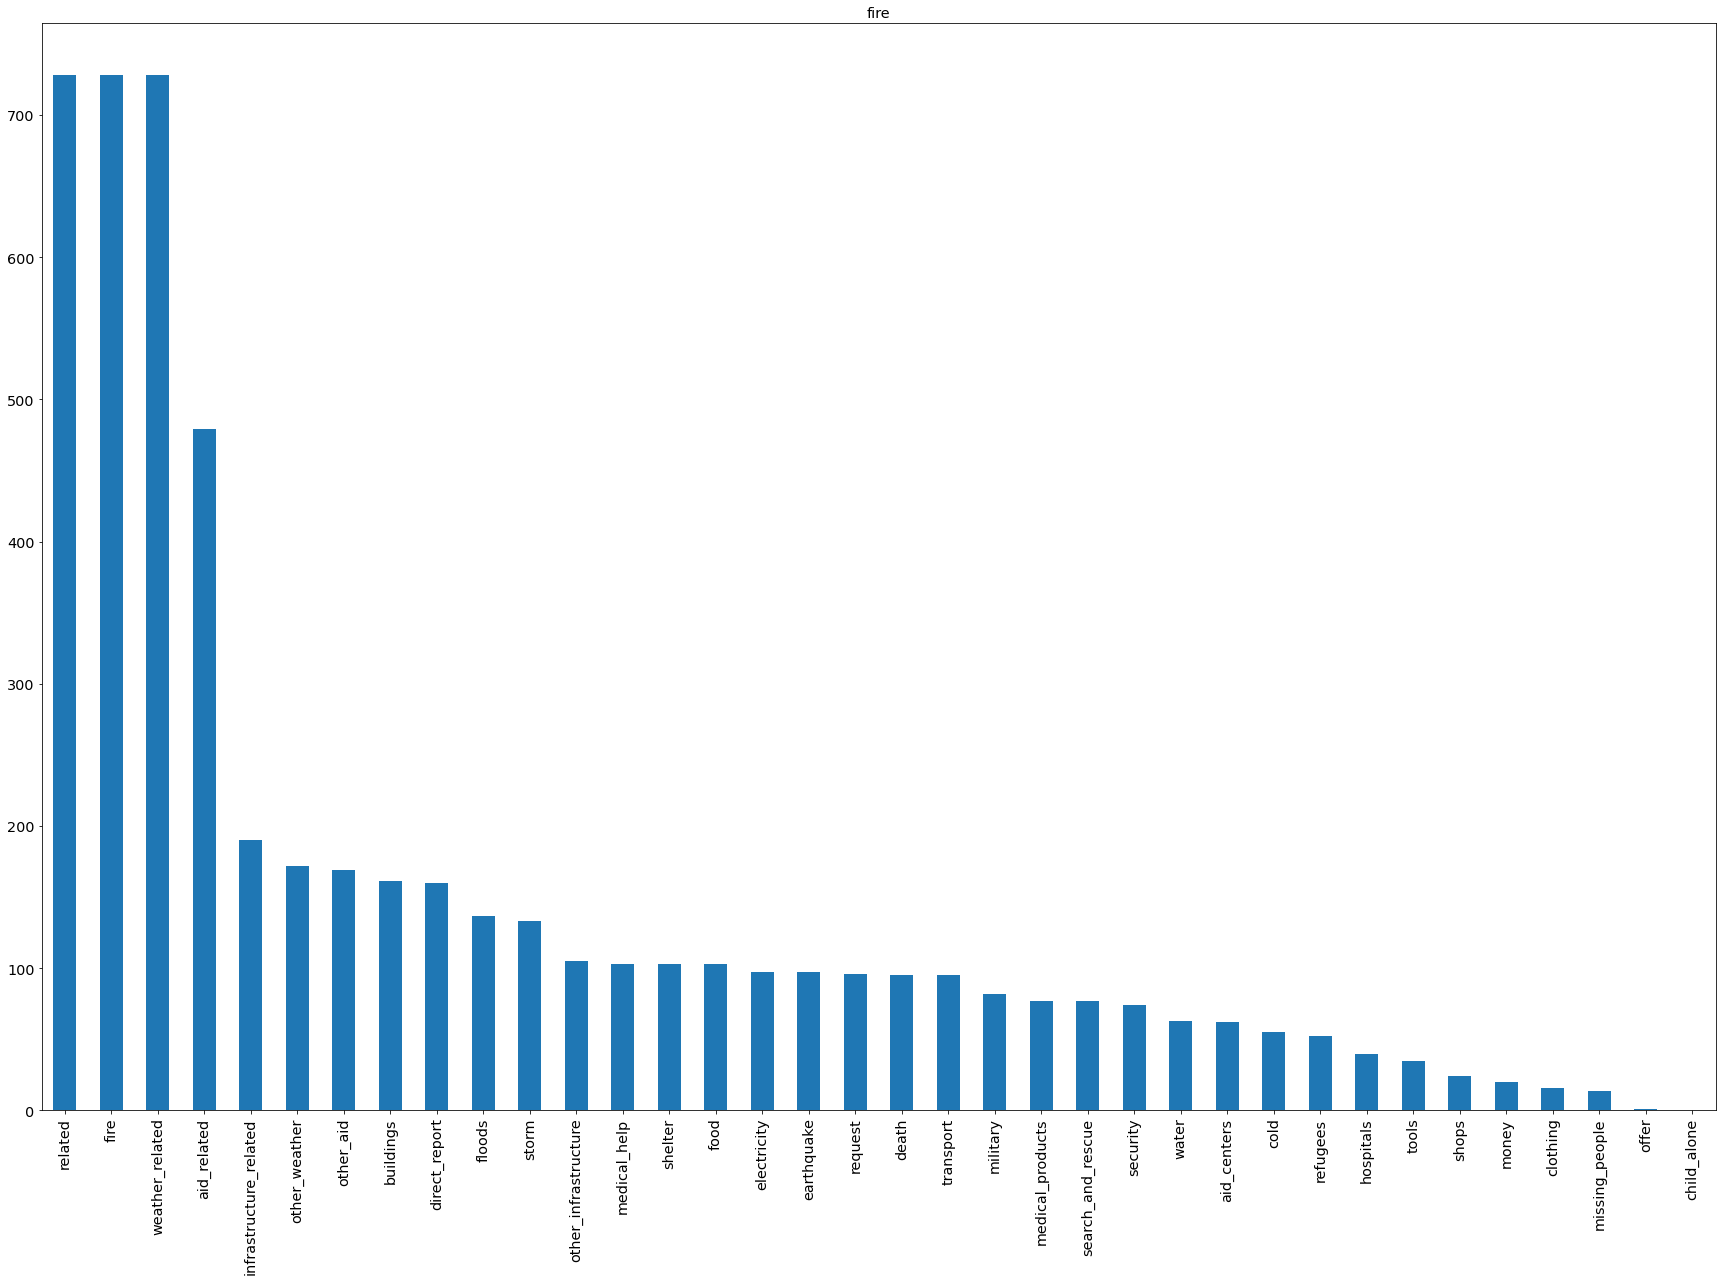

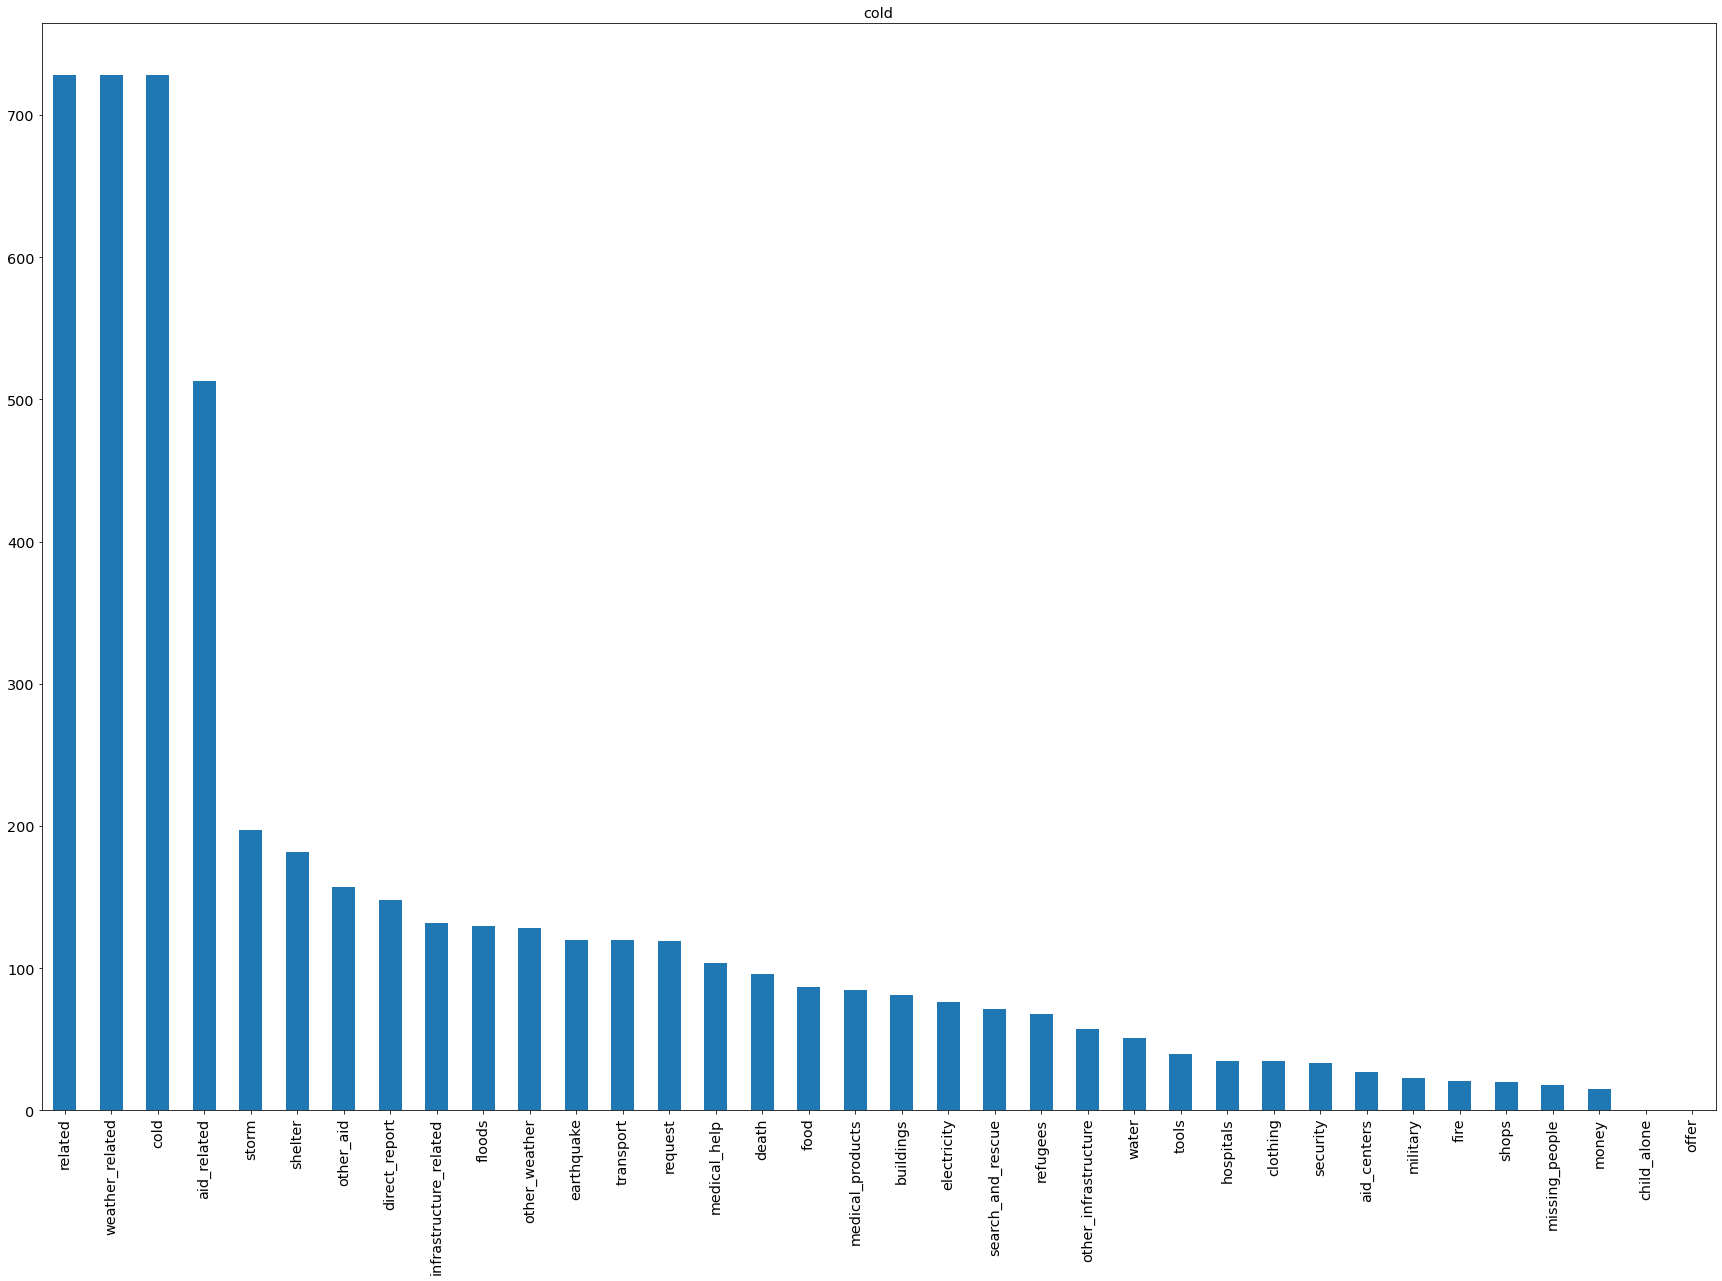

In [59]:
index = []
for c in categories_to_upsample:
    partial_df = Y[Y[c] == 1 ]
    if partial_df.shape[0] >0:
        sample_df = partial_df.sample(replace=True,n=occurence_target).reset_index()
        sample_df.drop(columns='index').sum().sort_values(ascending=False).plot.bar()
        plt.title(c)
        plt.show()
        index+=(sample_df['index'].tolist())
        

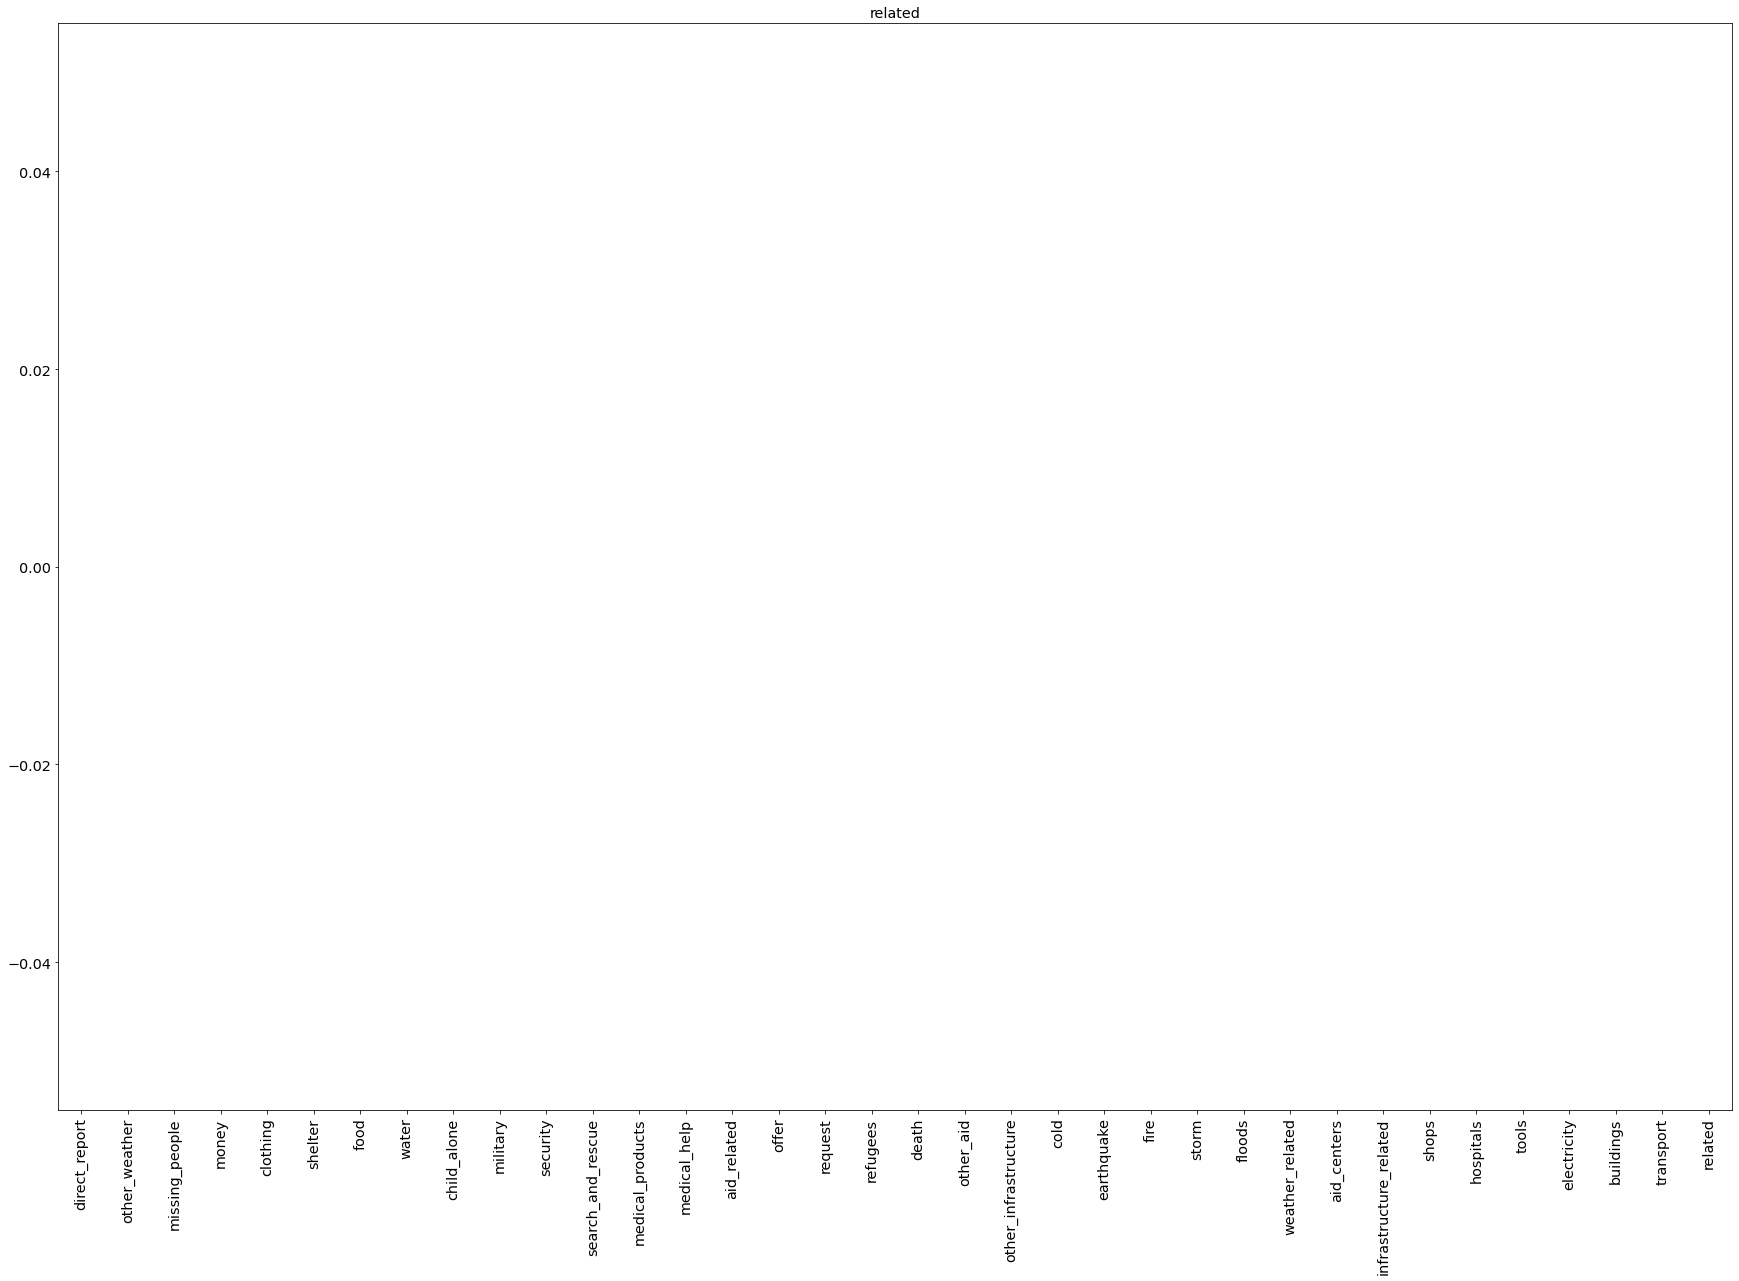

In [61]:
# adding data where related = 0
partial_df = Y[Y['related'] == 0 ]
sample_df = partial_df.sample(replace=True,n=occurence_target).reset_index()
sample_df.drop(columns='index').sum().sort_values(ascending=False).plot.bar()
plt.title('related')
plt.show()
index+=(partial_df.index.tolist())

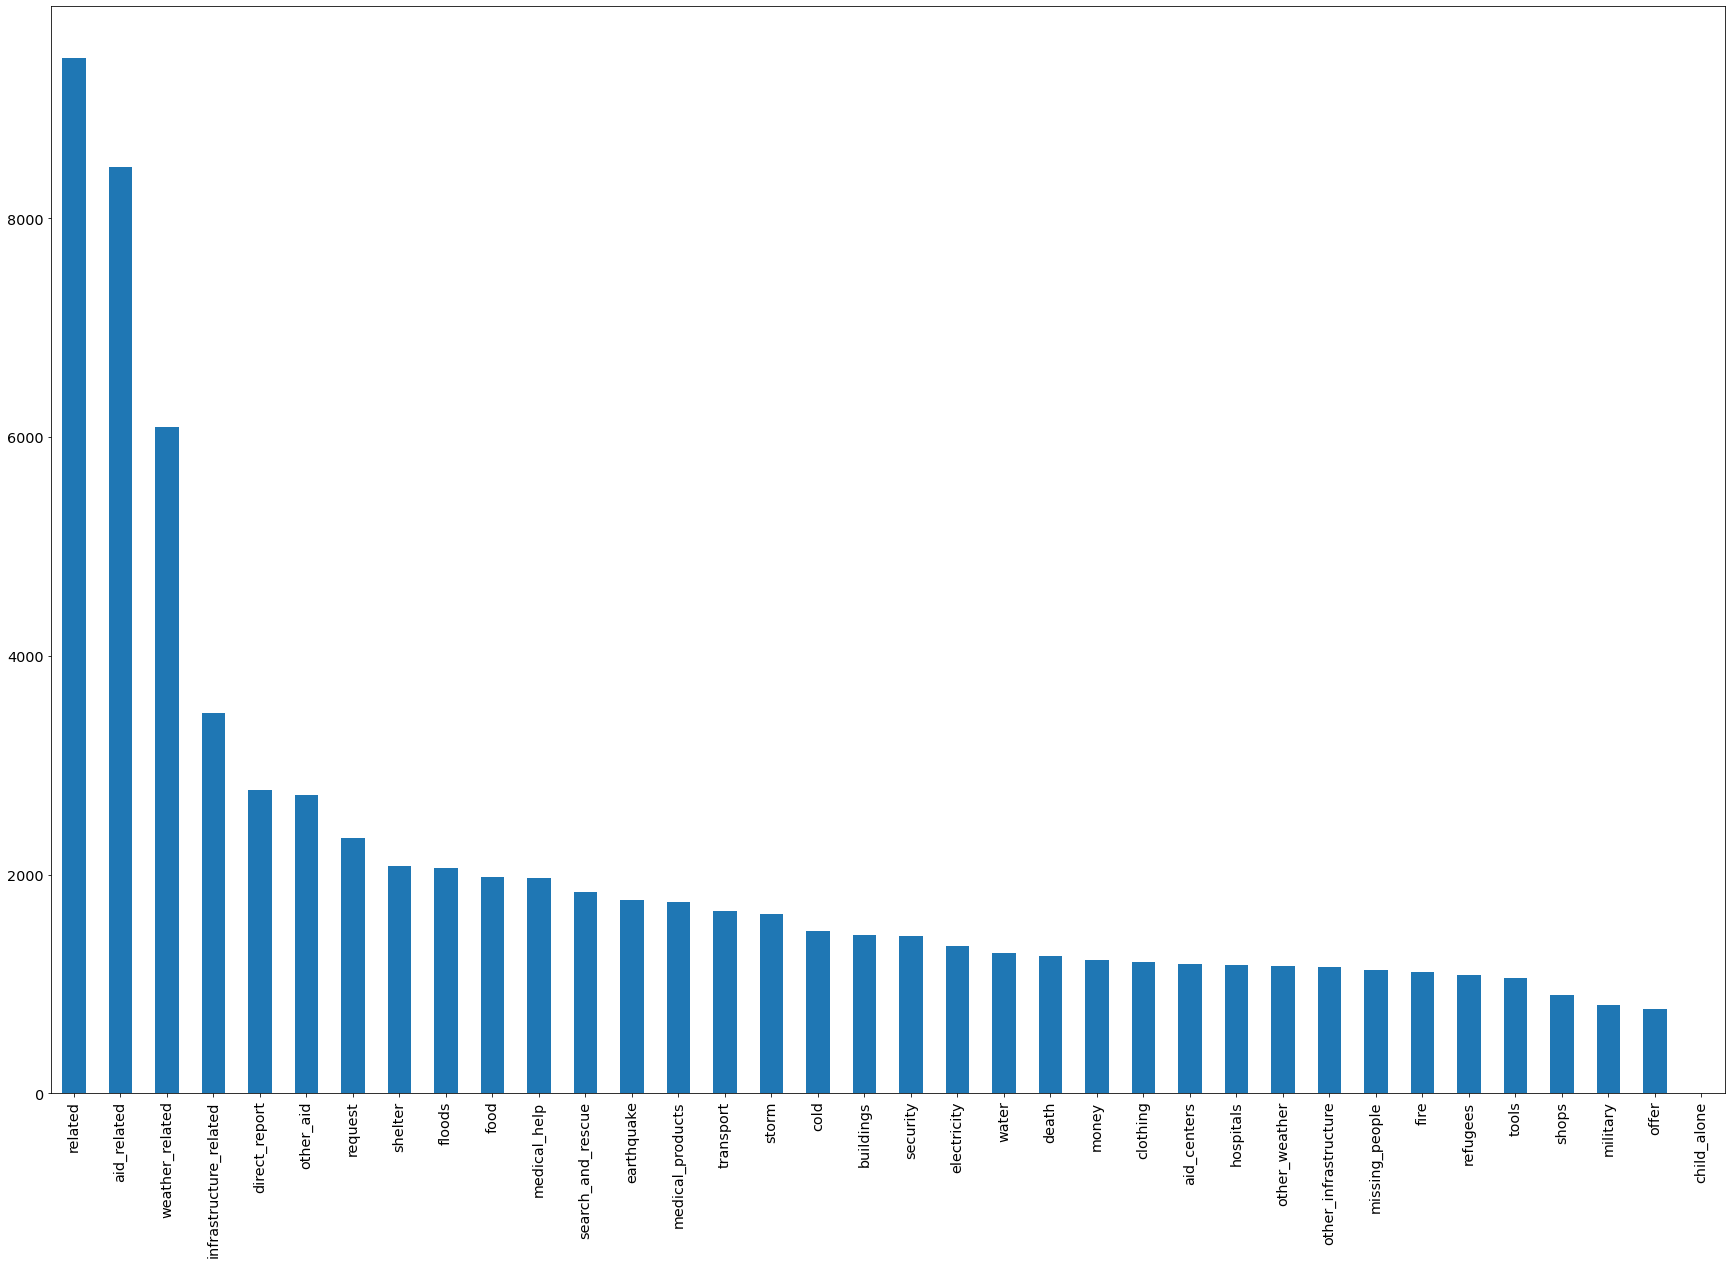

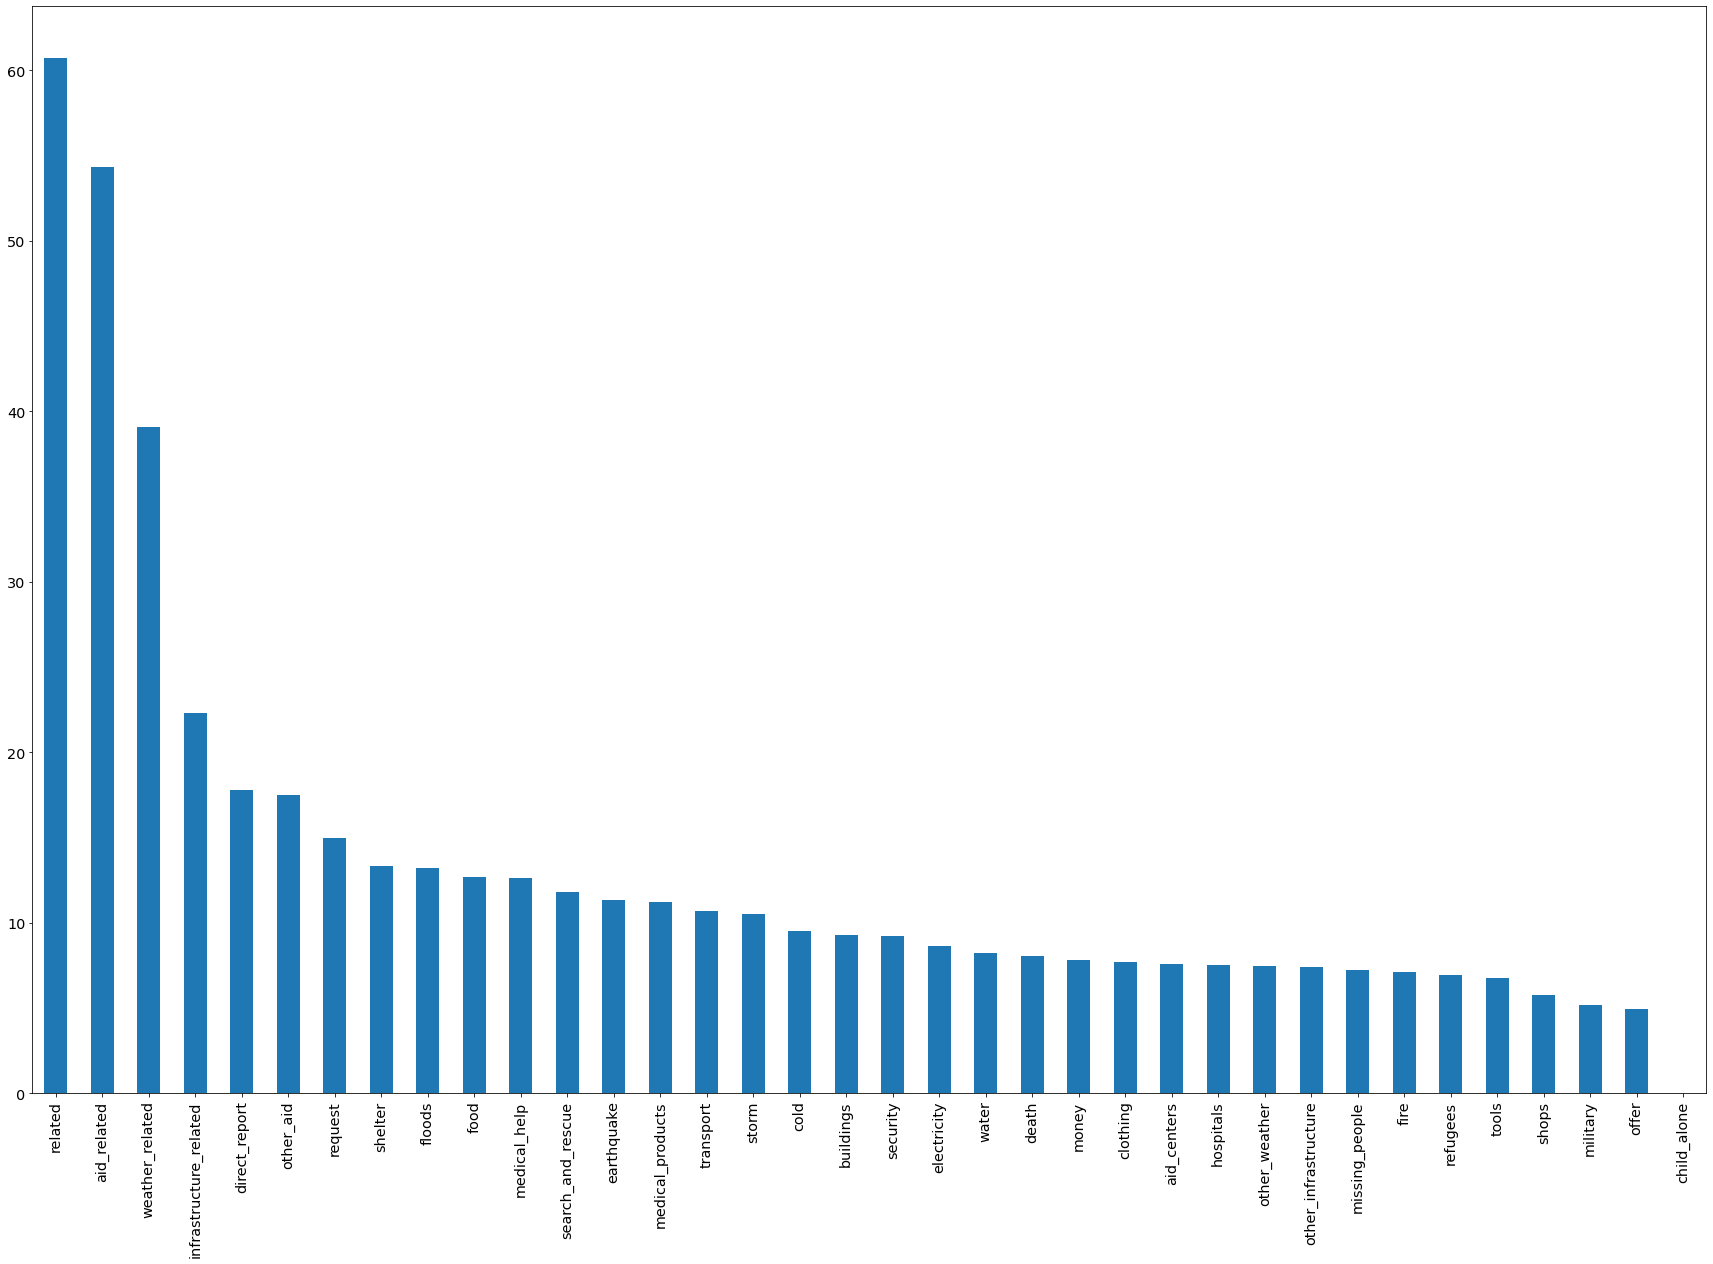

In [62]:
X_new = X[index]
Y_new = Y.iloc[index]

occurences_new = Y_new.sum()
occurences_new.sort_values(ascending=False).plot.bar()
plt.show()
occurences_pct_new = occurences_new/Y_new.shape[0]*100

occurences_pct_new.sort_values(ascending=False).plot.bar()
plt.show()

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    text = re.sub(r"[^a-zA-Z0-9]"," ",text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [65]:
def build_pipeline():
    pipeline = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('clf', MultiOutputClassifier(RandomForestClassifier()))
                        ])
    return pipeline

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [12]:
def train(X,Y,model):
    X_train, X_test, y_train, y_test = train_test_split(X,Y) 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.DataFrame(y_pred, index = y_test.index, columns = y_test.columns)
    return X_train, X_test, y_train, y_test, y_pred
model = build_pipeline()
X_train, X_test, y_train, y_test, y_pred = train(X,Y,model)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

Testing model on unbalanced dataset

In [35]:
def display_results(y_test, y_pred):
    for i in range(y_test.shape[1]):
        print(70*'='+'\nFeature: ',Y.columns[i])
        print(classification_report(y_test.iloc[:,i],y_pred.iloc[:,i]))

In [14]:
display_results(y_test,y_pred)

Feature:  related
              precision    recall  f1-score   support

           0       0.69      0.40      0.51      1534
           1       0.83      0.94      0.88      4965
           2       0.79      0.27      0.41        55

    accuracy                           0.81      6554
   macro avg       0.77      0.54      0.60      6554
weighted avg       0.80      0.81      0.79      6554

Feature:  request
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5374
           1       0.84      0.50      0.63      1180

    accuracy                           0.89      6554
   macro avg       0.87      0.74      0.78      6554
weighted avg       0.89      0.89      0.88      6554

Feature:  offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6528
           1       0.00      0.00      0.00        26

    accuracy                           1.00      6554
   macro avg       0.5

/Users/lamiakasmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6454
           1       0.73      0.08      0.14       100

    accuracy                           0.99      6554
   macro avg       0.86      0.54      0.57      6554
weighted avg       0.98      0.99      0.98      6554

Feature:  money
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6404
           1       0.33      0.01      0.01       150

    accuracy                           0.98      6554
   macro avg       0.66      0.50      0.50      6554
weighted avg       0.96      0.98      0.97      6554

Feature:  missing_people
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6482
           1       1.00      0.01      0.03        72

    accuracy                           0.99      6554
   macro avg       0.99      0.51      0.51      6554
weighted avg       0.99      0.99

### 6. Improve your model
Use grid search to find better parameters. 

Creating an upsampling function to apply on the training data to improve the predictions

In [25]:
def upsample_data(X,Y):
    """
    Upsample lowest occuring categories
    
    Input: 
    X: input messages
    Y: output classes
    
    Output:
    X_new: balanced sample of messages
    Y_new: corresponding balanced sample of output classes
    """
    
    df = pd.DataFrame(X).join(Y).reset_index().drop(columns='index')
    categories = Y.columns.tolist()
    occurences = Y.sum()
    occurence_target = int(Y.shape[0]/len(categories))
    categories_to_upsample = occurences[occurences <= occurence_target].index.tolist()

    index = []
    df_rest = df
    
    for c in categories_to_upsample:
        classes = list(df_rest[c].unique())
        classes.remove(0)
        occurence_target = df_rest[df_rest[c] == 0].shape[0]
        for cl in classes:
            df_to_upsample = df_rest.loc[df_rest[c] == cl]
            
            #removing the rows to upsample from df
            df_rest = df_rest.loc[df_rest[c] != cl]
        
        if df_to_upsample.shape[0] >0:
            sample_df = df_to_upsample.sample(replace=True,n=occurence_target).reset_index()
            index+=(sample_df['index'].tolist())
    
    upsampled_df = df.iloc[index].reset_index().drop(columns='index')
    df_rest = df_rest.reset_index().drop(columns='index')

    # Adding non related messages
    unrelated_df = df[df['related'] == 0].reset_index().drop(columns='index')

    # merging untouched rows with upsampled ones and unrelated messages
    df_new = pd.concat([df_rest,upsampled_df, unrelated_df]).reset_index().drop(columns='index')
    X_new = df_new['message']
    Y_new = df_new.iloc[:,1:]

    occurences_new = Y_new.sum()
    occurences_new.sort_values(ascending=False).plot.bar()
    plt.show()
    occurences_pct_new = occurences_new/Y_new.shape[0]*100

    occurences_pct_new.sort_values(ascending=False).plot.bar()
    plt.show()

    return X_new, Y_new

Split the dataset into a validation and training dataset, upsampling is applied on the training dataset

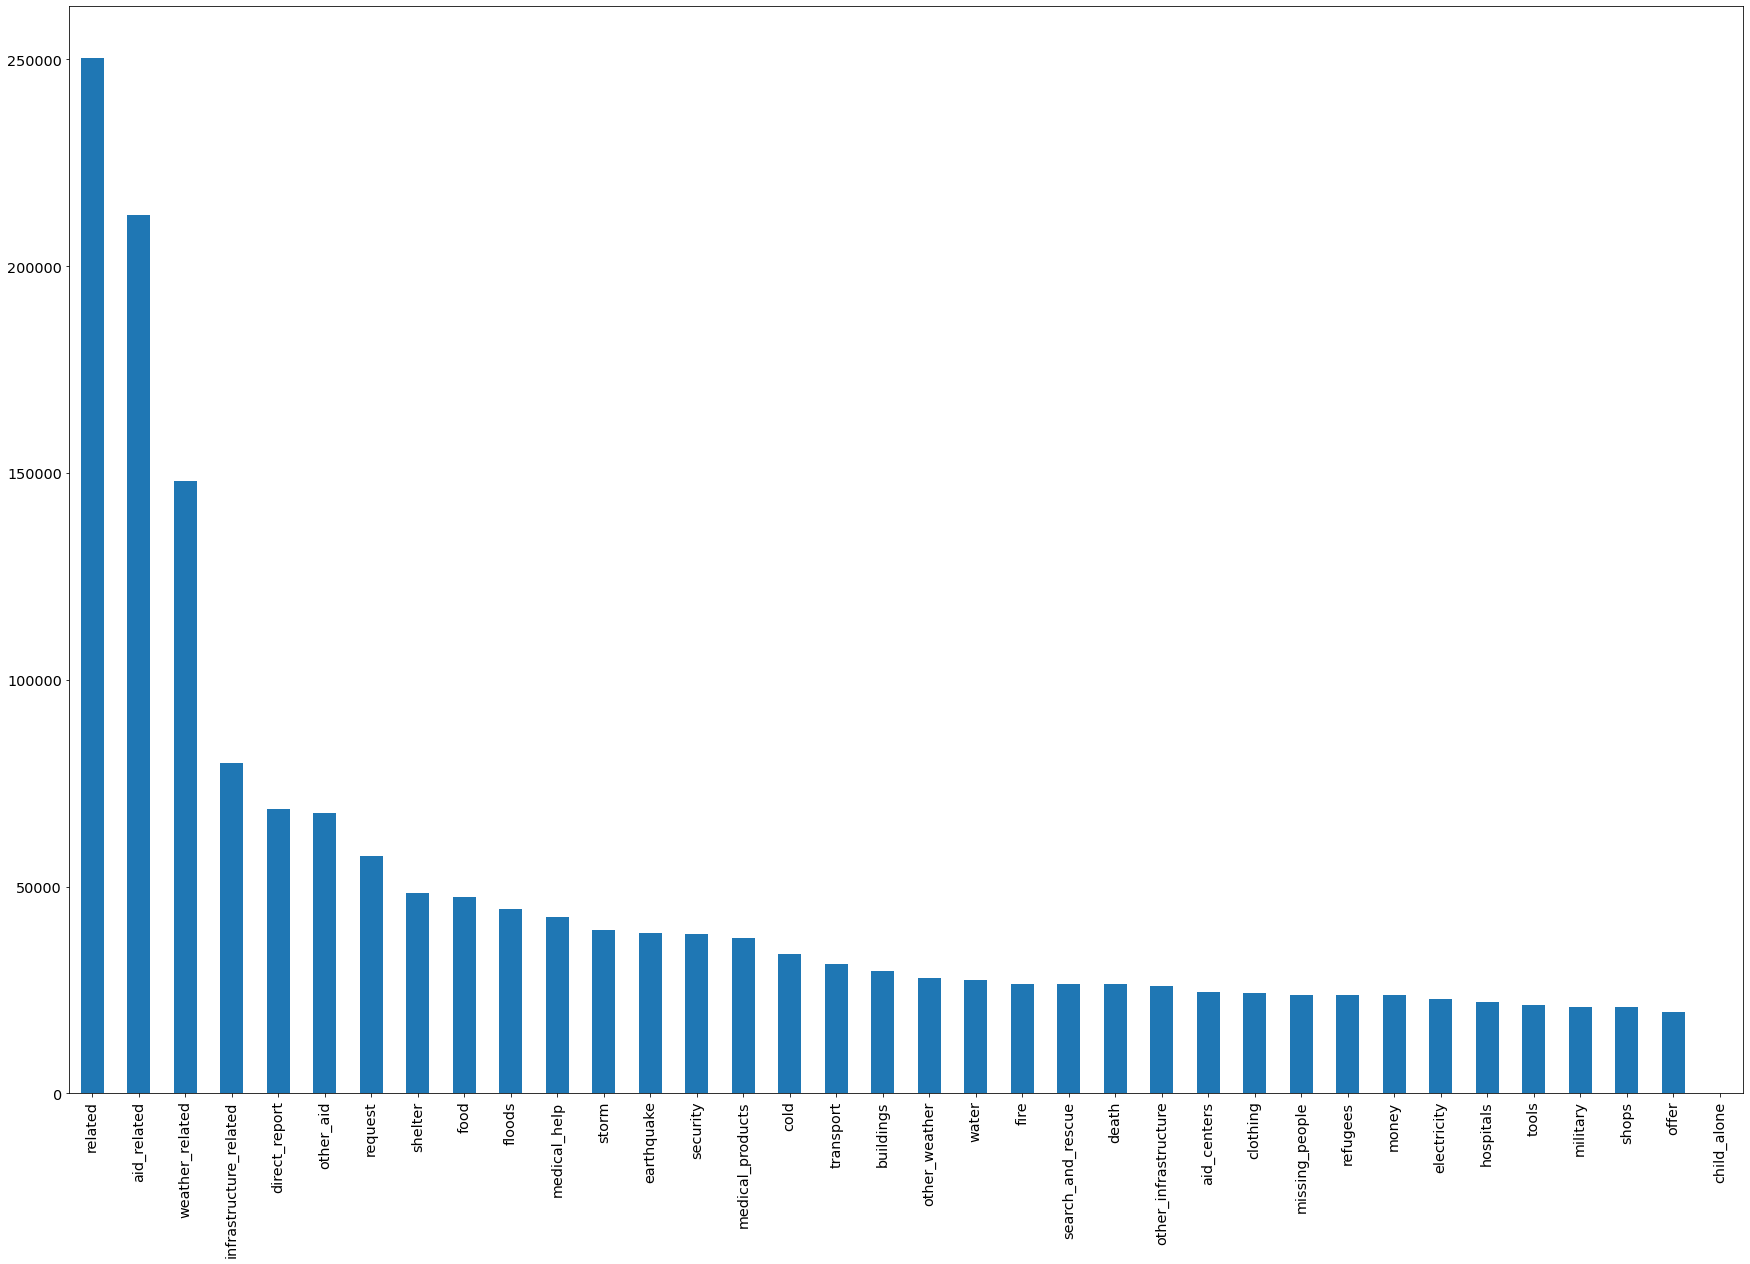

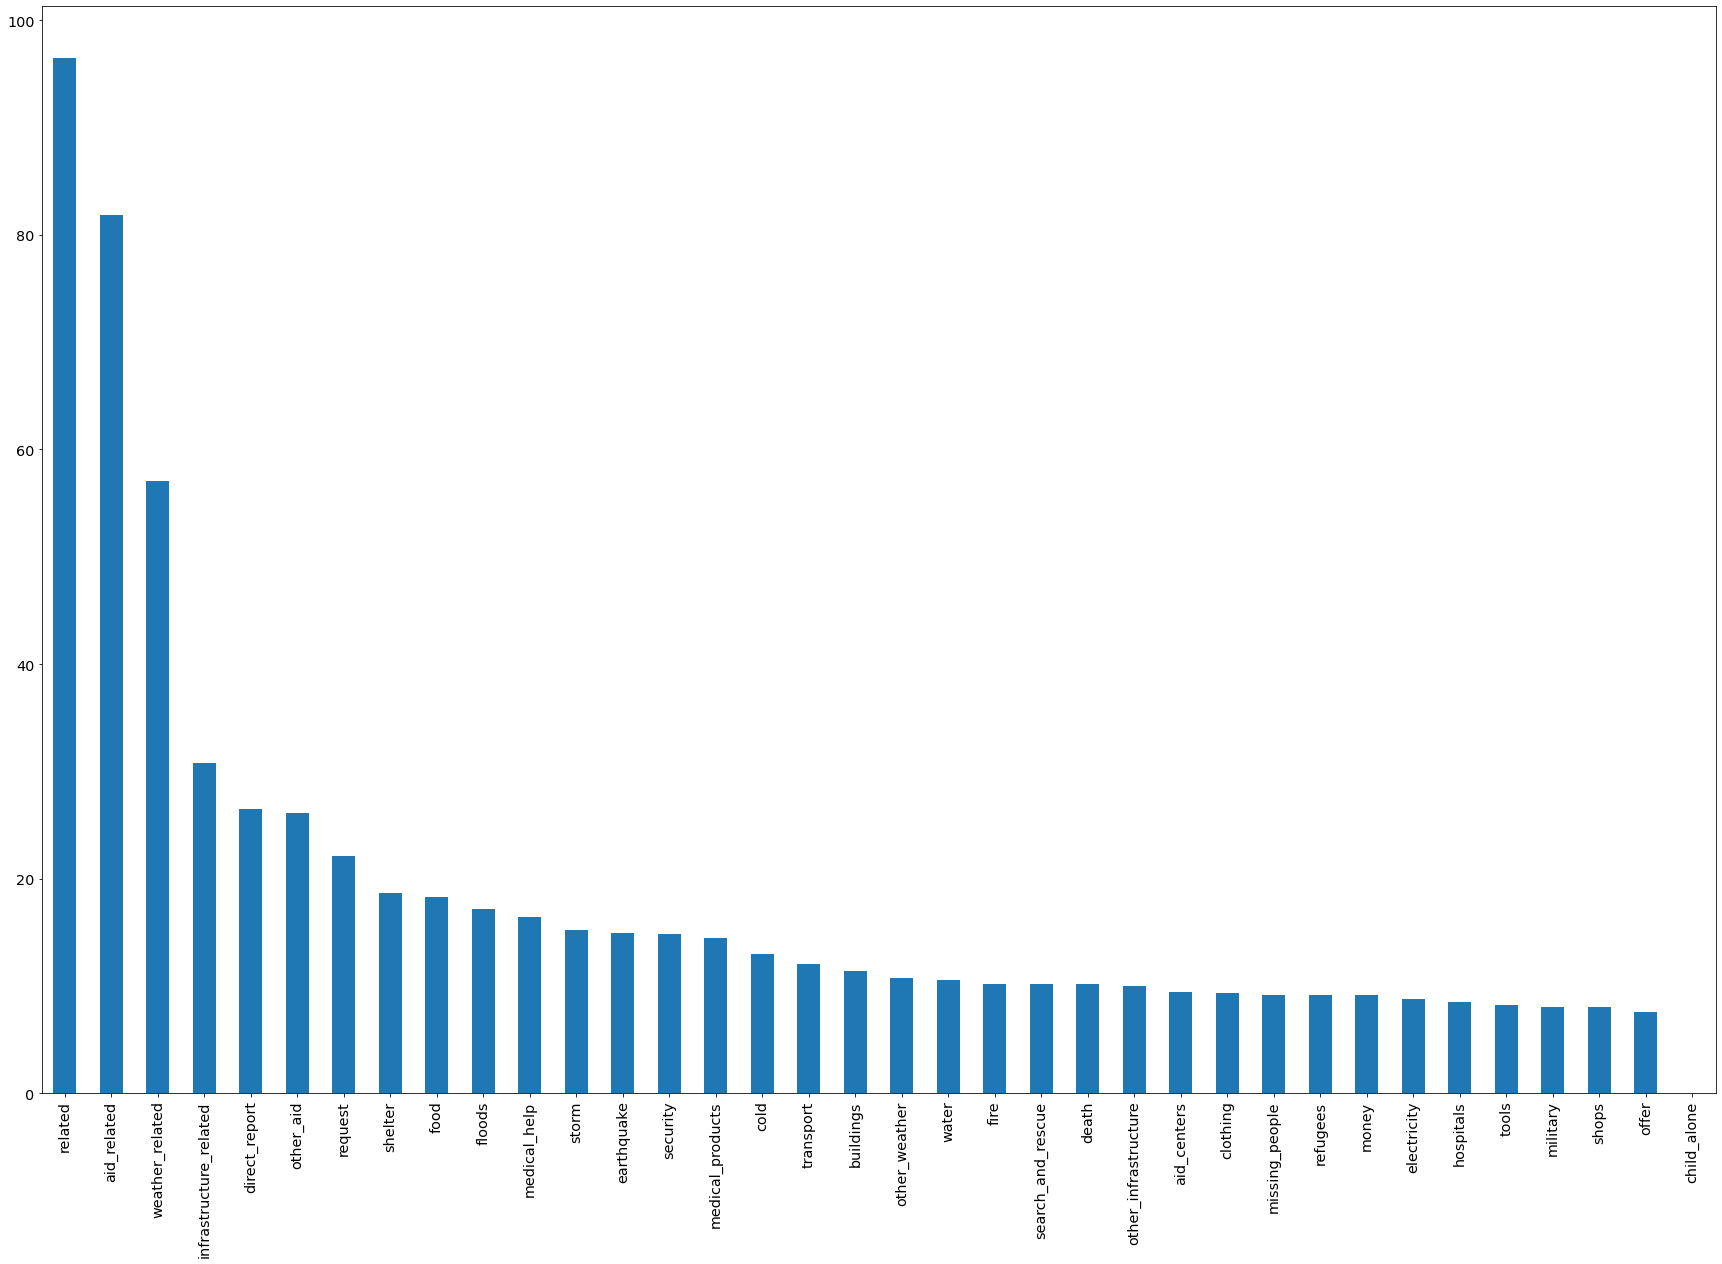

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X,Y) 
X_new, Y_new = upsample_data(X_train,y_train)

In [31]:
def build_model():
    pipeline = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('clf', MultiOutputClassifier(RandomForestClassifier()))
                        ])
    return pipeline


In [32]:
def train_model(X,Y,model):
    X_train, X_test, y_train, y_test = train_test_split(X,Y) 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.DataFrame(y_pred, index = y_test.index, columns = y_test.columns)    
    return X_train, X_test, y_train, y_test, y_pred

model = build_model()
X_train, X_test, y_train, y_test, y_pred = train_model(X_new,Y_new,model)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [36]:
display_results(y_test,y_pred)

Feature:  related
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      2315
           1       1.00      0.99      0.99     62523
           2       0.28      0.47      0.35        34

    accuracy                           0.99     64872
   macro avg       0.70      0.78      0.73     64872
weighted avg       0.99      0.99      0.99     64872

Feature:  request
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     50485
           1       1.00      0.97      0.98     14387

    accuracy                           0.99     64872
   macro avg       0.99      0.99      0.99     64872
weighted avg       0.99      0.99      0.99     64872

Feature:  offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59865
           1       1.00      1.00      1.00      5007

    accuracy                           1.00     64872
   macro avg       1.0

### Test on validation dataset which is a sample of the original not upsampled dataset

In [ ]:
y_pred_valid = model.predict(X_valid)


In [38]:
y_pred_valid=pd.DataFrame(y_pred_valid, index = y_valid.index, columns = y_valid.columns) 
display_results(y_valid,y_pred_valid)

Feature:  related
              precision    recall  f1-score   support

           0       0.56      0.49      0.52      1462
           1       0.86      0.88      0.87      5045
           2       0.26      0.43      0.33        47

    accuracy                           0.79      6554
   macro avg       0.56      0.60      0.57      6554
weighted avg       0.79      0.79      0.79      6554

Feature:  request
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5427
           1       0.82      0.46      0.59      1127

    accuracy                           0.89      6554
   macro avg       0.86      0.72      0.76      6554
weighted avg       0.88      0.89      0.88      6554

Feature:  offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6516
           1       0.00      0.00      0.00        38

    accuracy                           0.99      6554
   macro avg       0.5

/Users/lamiakasmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 9. Export your model as a pickle file

In [40]:
import pickle
def save_model(model, model_filepath):
    """
    Dump model into pickle file

    Input:
    model: sklearn model
    model_filepath: filepath where model should be stored
    """
    pickle.dump(model, open(model_filepath, "wb"))
    
save_model(model,'./classifier.pkl')

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

It seems that the classifier trained on teh unbalanced datset, performs better than the one trained on the upsampled one. 